In [64]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns
sns.set('notebook')
from __future__ import division
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (18,8)
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
%config InlineBackend.figure_format = 'retina'

In [65]:
def clean_dataframe(df):
    df.dropna(axis=1,how='all',inplace=True)
    columns_navalue =  df.columns[df.isna().any()].tolist()
    # set last value
    if columns_navalue != []:
        df.ix[-1,columns_navalue] = df[columns_navalue].median()
        df[columns_navalue] = df[columns_navalue].interpolate()

In [157]:
# sns.set_style("whitegrid")
def plot_df(df,plt_dic,by_month = False,title ='Tourist'):
    col_name = 'Year'
    if by_month == True:
        df = df.T
        col_name = 'Month'
    info = df.sum().to_frame().reset_index()
    info.columns = [col_name,'Currency']
    ax = sns.barplot(data=info,x=col_name,y='Currency')
    for i, v in enumerate(info.Currency.values):
        ax.text(i-.2 , v+v*.01 , str('%.1fM'%(v/1000)), color='black', fontweight='bold')
    xx, locs = plt.yticks()
    ll = ['{:,}'.format(a) for a in xx]
    plt.yticks(xx[:-1], ll[:-1])
    plt.title(title)
    plt.ylabel(plt_dic['y_label'])
    plt.tight_layout()
    plt.show();

In [158]:
def show_data(name_file,xls_dic,plt_dic,drop=0,by_month = False,title ='Tourist'):
    df = pd.read_excel(name_file,**xls_dic)
    df = df.iloc[:,:(-1*drop+-1)]
    clean_dataframe(df)
    plot_df(df,plt_dic,by_month,title)

In [159]:
date_dic = dict(Enero=1,Febrero=2,Marzo=3,Abril=4,Mayo=5,Junio=6,Julio=7,
           Agosto=8,Septiembre=9,Octubre=10,Noviembre=11,Diciembre=12)

def predict_plot(name_file,dic,drop=0,title='Predict Plot'):
    df = pd.read_excel(name_file,**dic)
    df = df.iloc[:,:(-1*drop+-1)]
    clean_dataframe(df)
    df = pd.melt(df.reset_index(), 
                id_vars='index', 
                value_vars=list(df.columns[1:]), # list of days of the week
                var_name='Year', 
                value_name='Sum of Tourist')
    df['Date'] = df['index'].map(date_dic)
    df.Date = df.apply(lambda row: pd.datetime(int(row['Year']), row['Date'],1), axis=1)
    df.set_index('Date',inplace=True)
    mod = sm.tsa.statespace.SARIMAX(df['Sum of Tourist'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    pred = results.get_prediction(start=pd.to_datetime('2017-09-01'),
                                  end=pd.to_datetime('2021-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = df['2004':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Count Tourist')
    plt.title(title)
    plt.legend()
    plt.show();

In [160]:
def clean_dataframe_area(df):
    df.dropna(axis=1,how='all',inplace=True)
    columns_navalue =  df.columns[df.isna().any()].tolist()
    # set last value
    if columns_navalue != []:
        df.ix[-1,columns_navalue] = df[columns_navalue].median()
        df[columns_navalue] = df[columns_navalue].interpolate()
        
def plot_df_area(df,plt_dic,title ='Tourist'):
    df = df.T
    col_name = 'Region'
    dic = dict(y=col_name,x='Tourist_count')
    info = df.sum().to_frame().reset_index()
    info.columns = [col_name,'Tourist_count']
    info = info.sort_values(['Tourist_count'],ascending=False).head(10)
    sns.barplot(data=info,**dic)
    plt.xscale(plt_dic['scale'])
    plt.xlabel(plt_dic['x_label'])
    plt.ylabel(plt_dic['y_label'])
    plt.title(title)
    plt.show();
        
def show_by(name_file,xls_dic,plt_dic,title ='Tourist'):
    df = pd.read_excel(name_file,**xls_dic,)
    df = df.loc[:,df.columns.map(lambda x: x.isalnum())]
    clean_dataframe_area(df)
    plot_df_area(df,plt_dic,title)

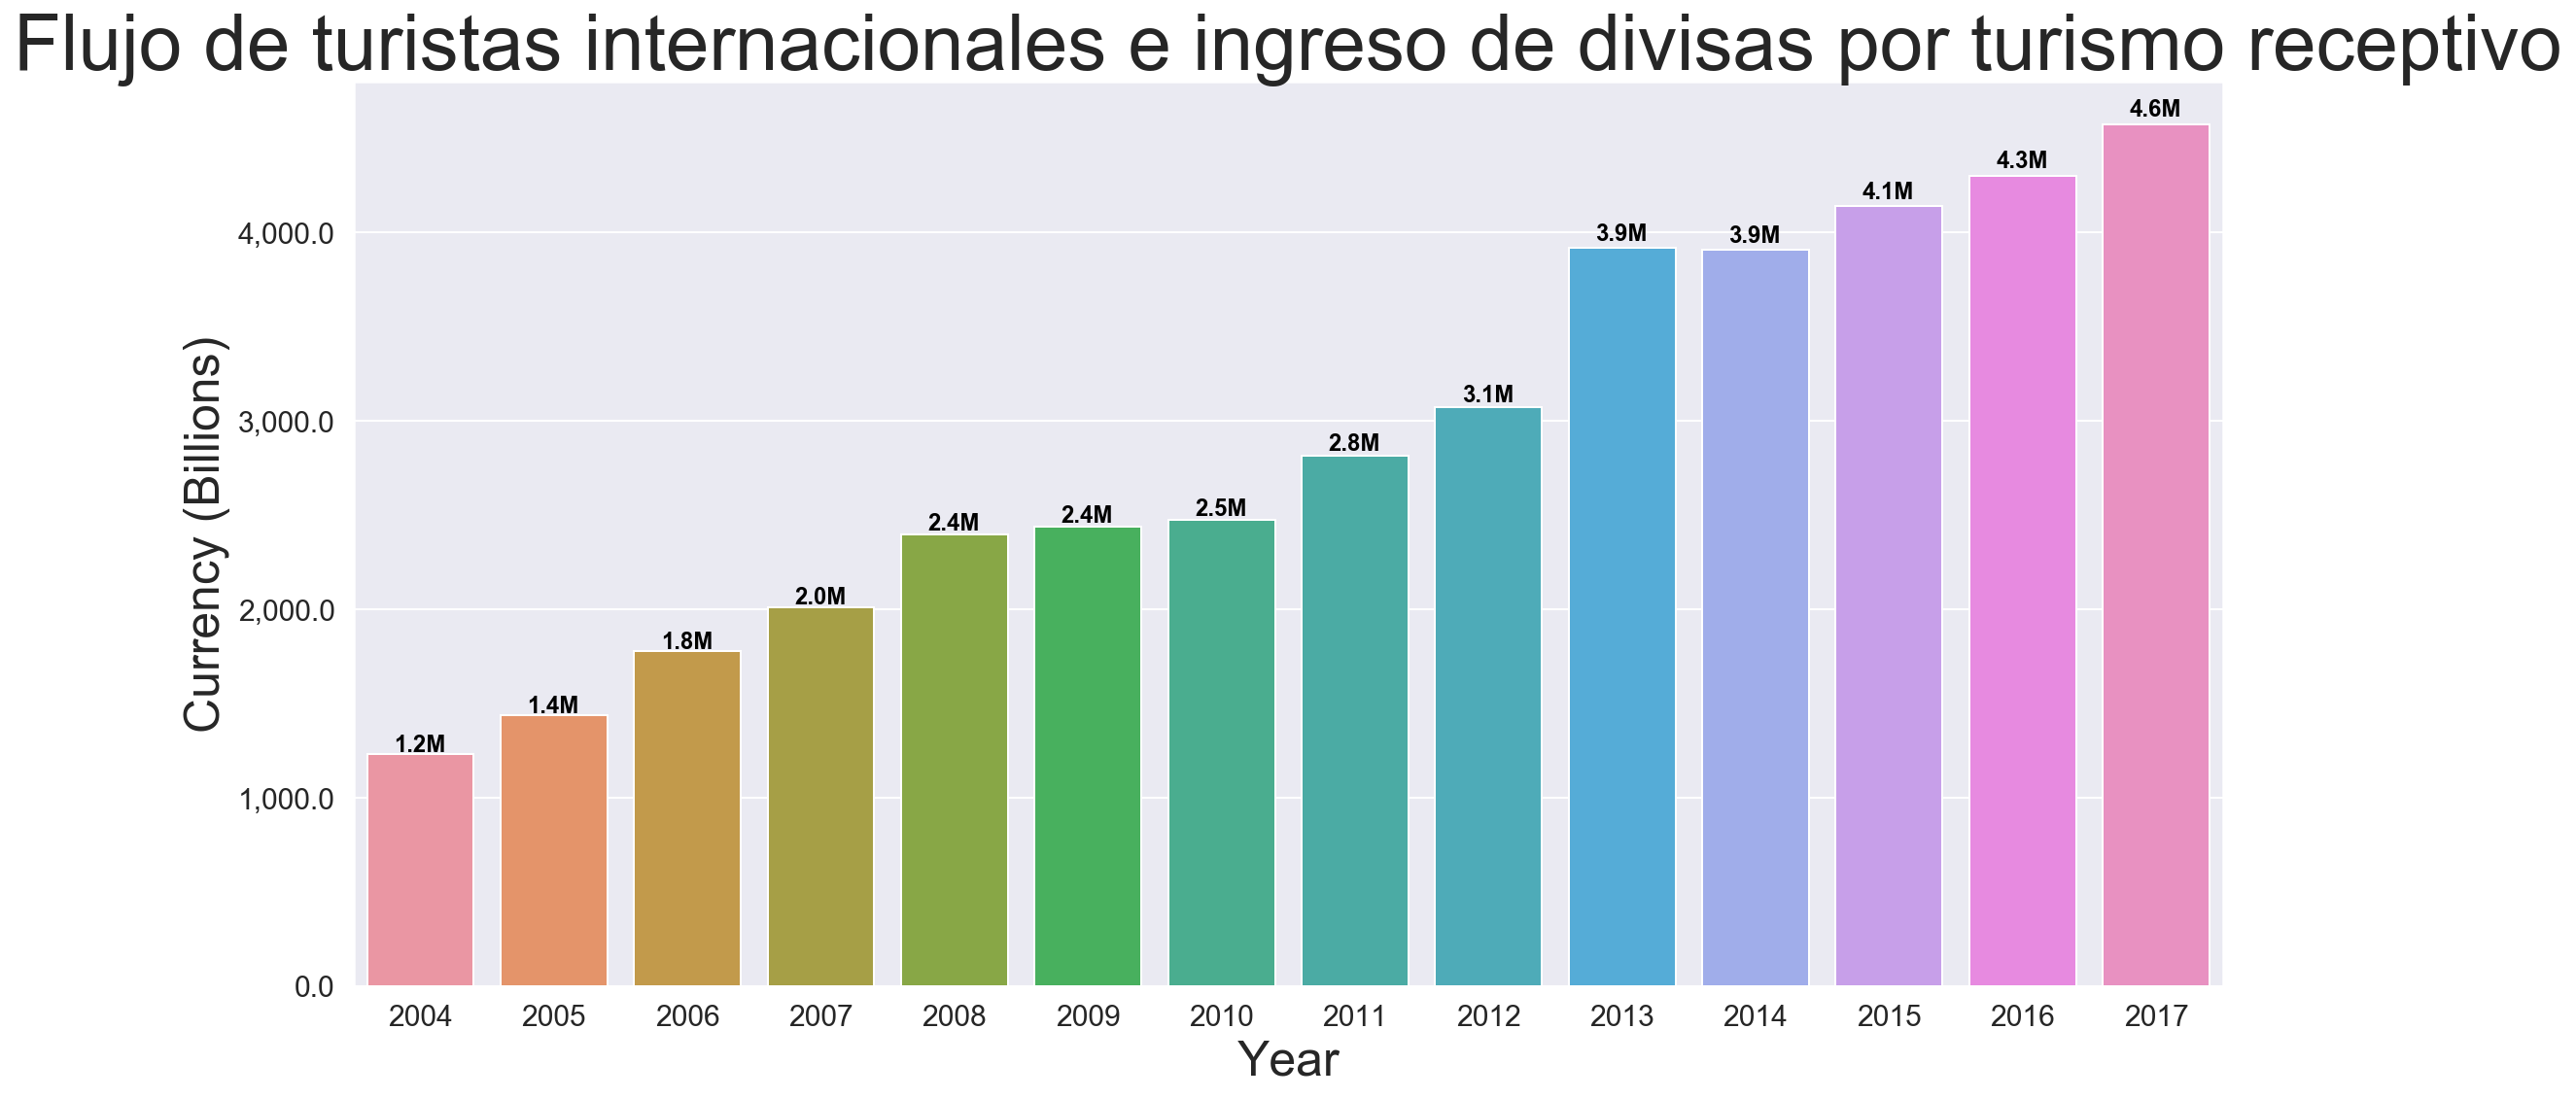

In [161]:
xls_dic = dict(sheet_name='rptaniomes',nrows=4,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Currency (Billions)',)
show_data('ingreso divisas.xls',xls_dic,plt_dic,
        title='Flujo de turistas internacionales e ingreso de divisas por turismo receptivo')

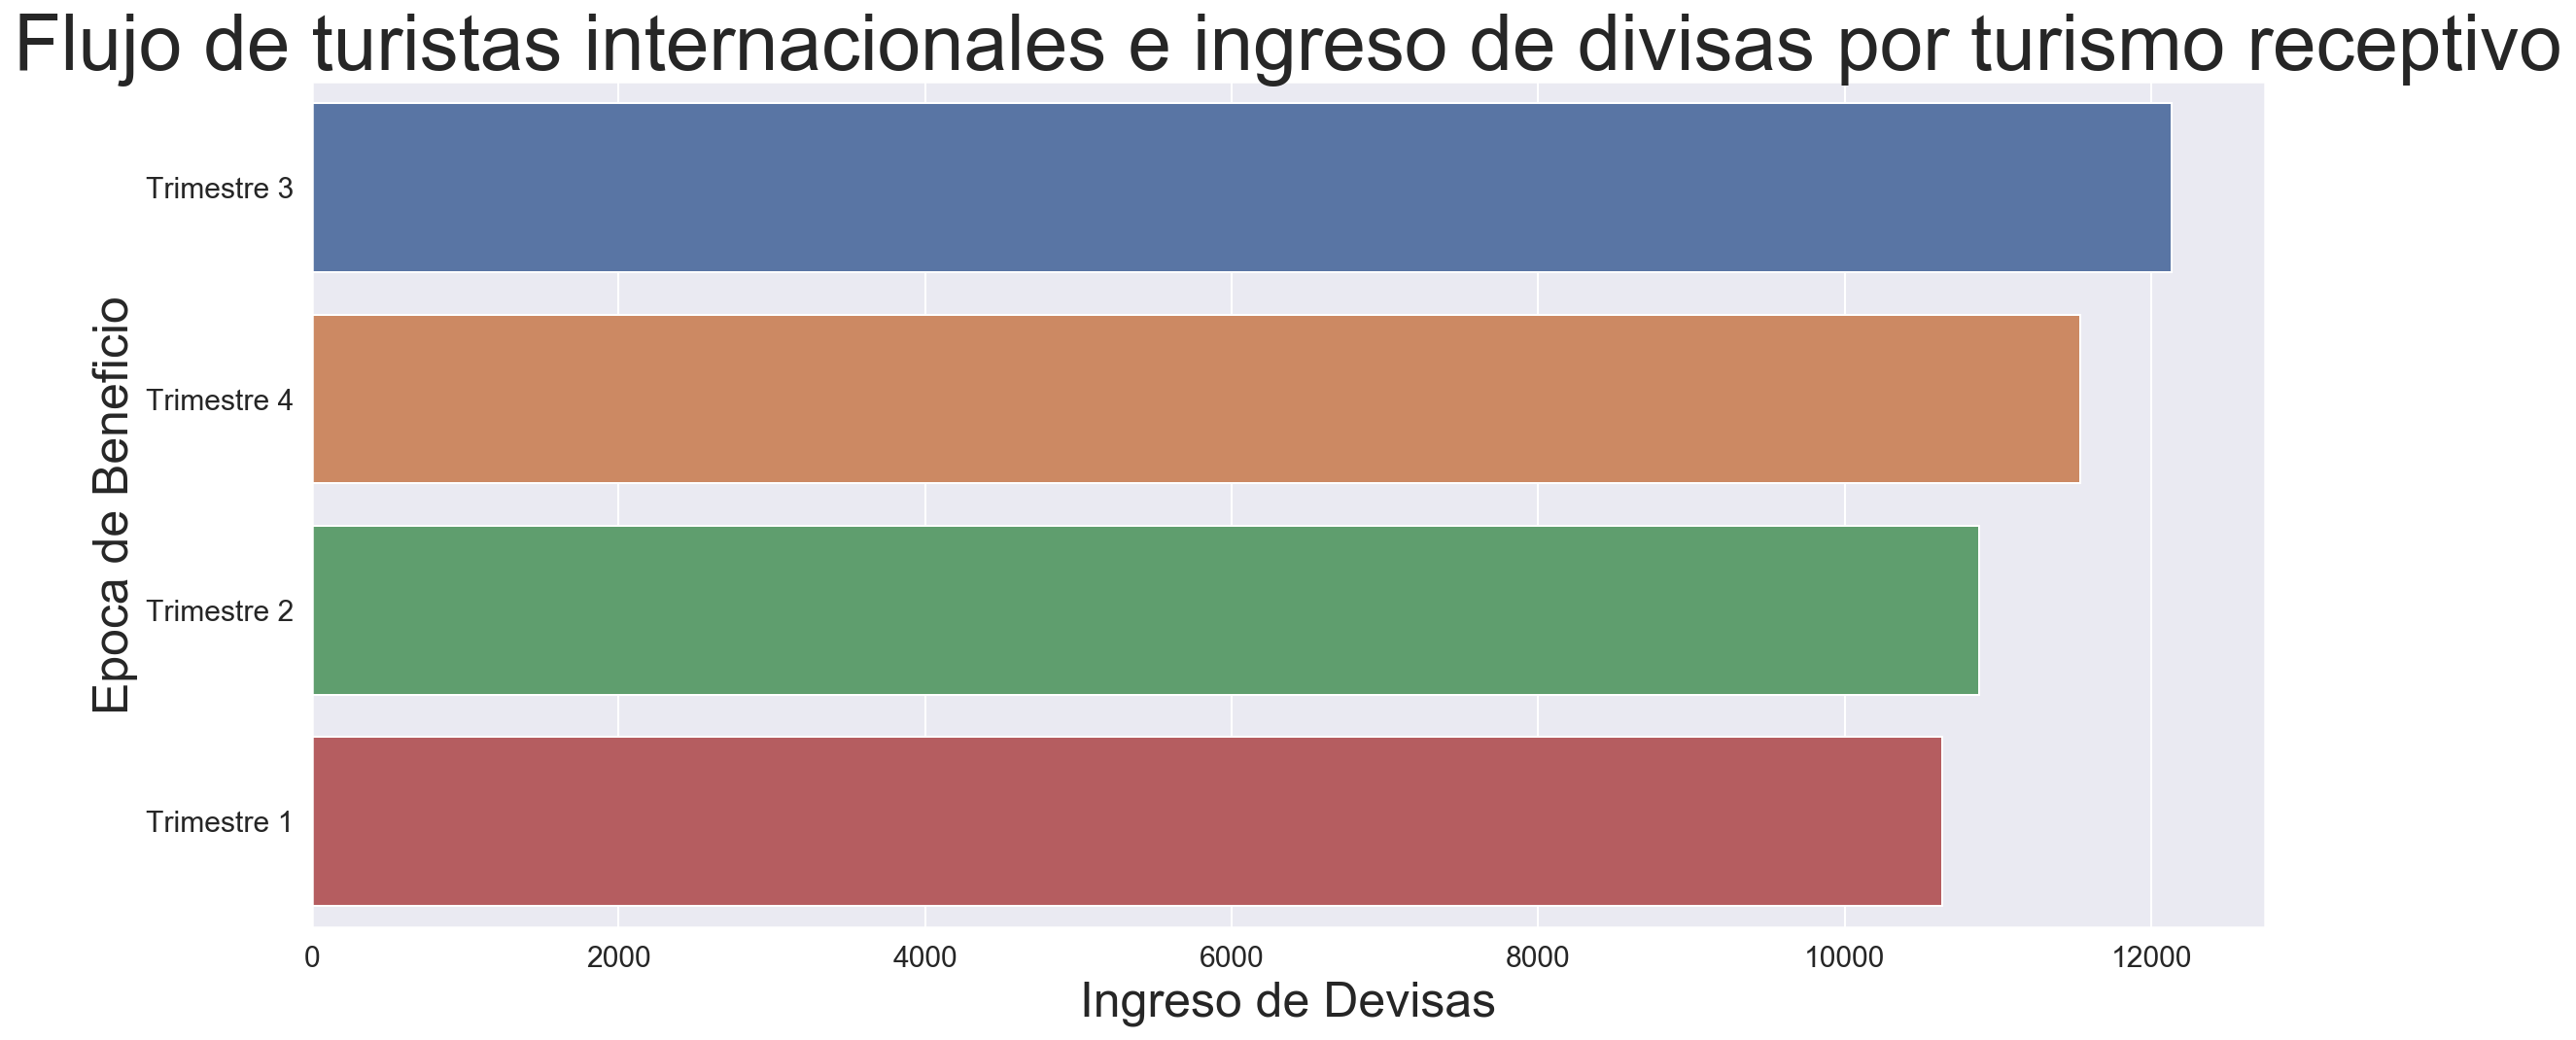

In [162]:
plt_dic = dict(y_label='Epoca de Beneficio',x_label='Ingreso de Devisas',scale='linear')
show_by('ingreso divisas.xls',xls_dic,plt_dic,
             'Flujo de turistas internacionales e ingreso de divisas por turismo receptivo')

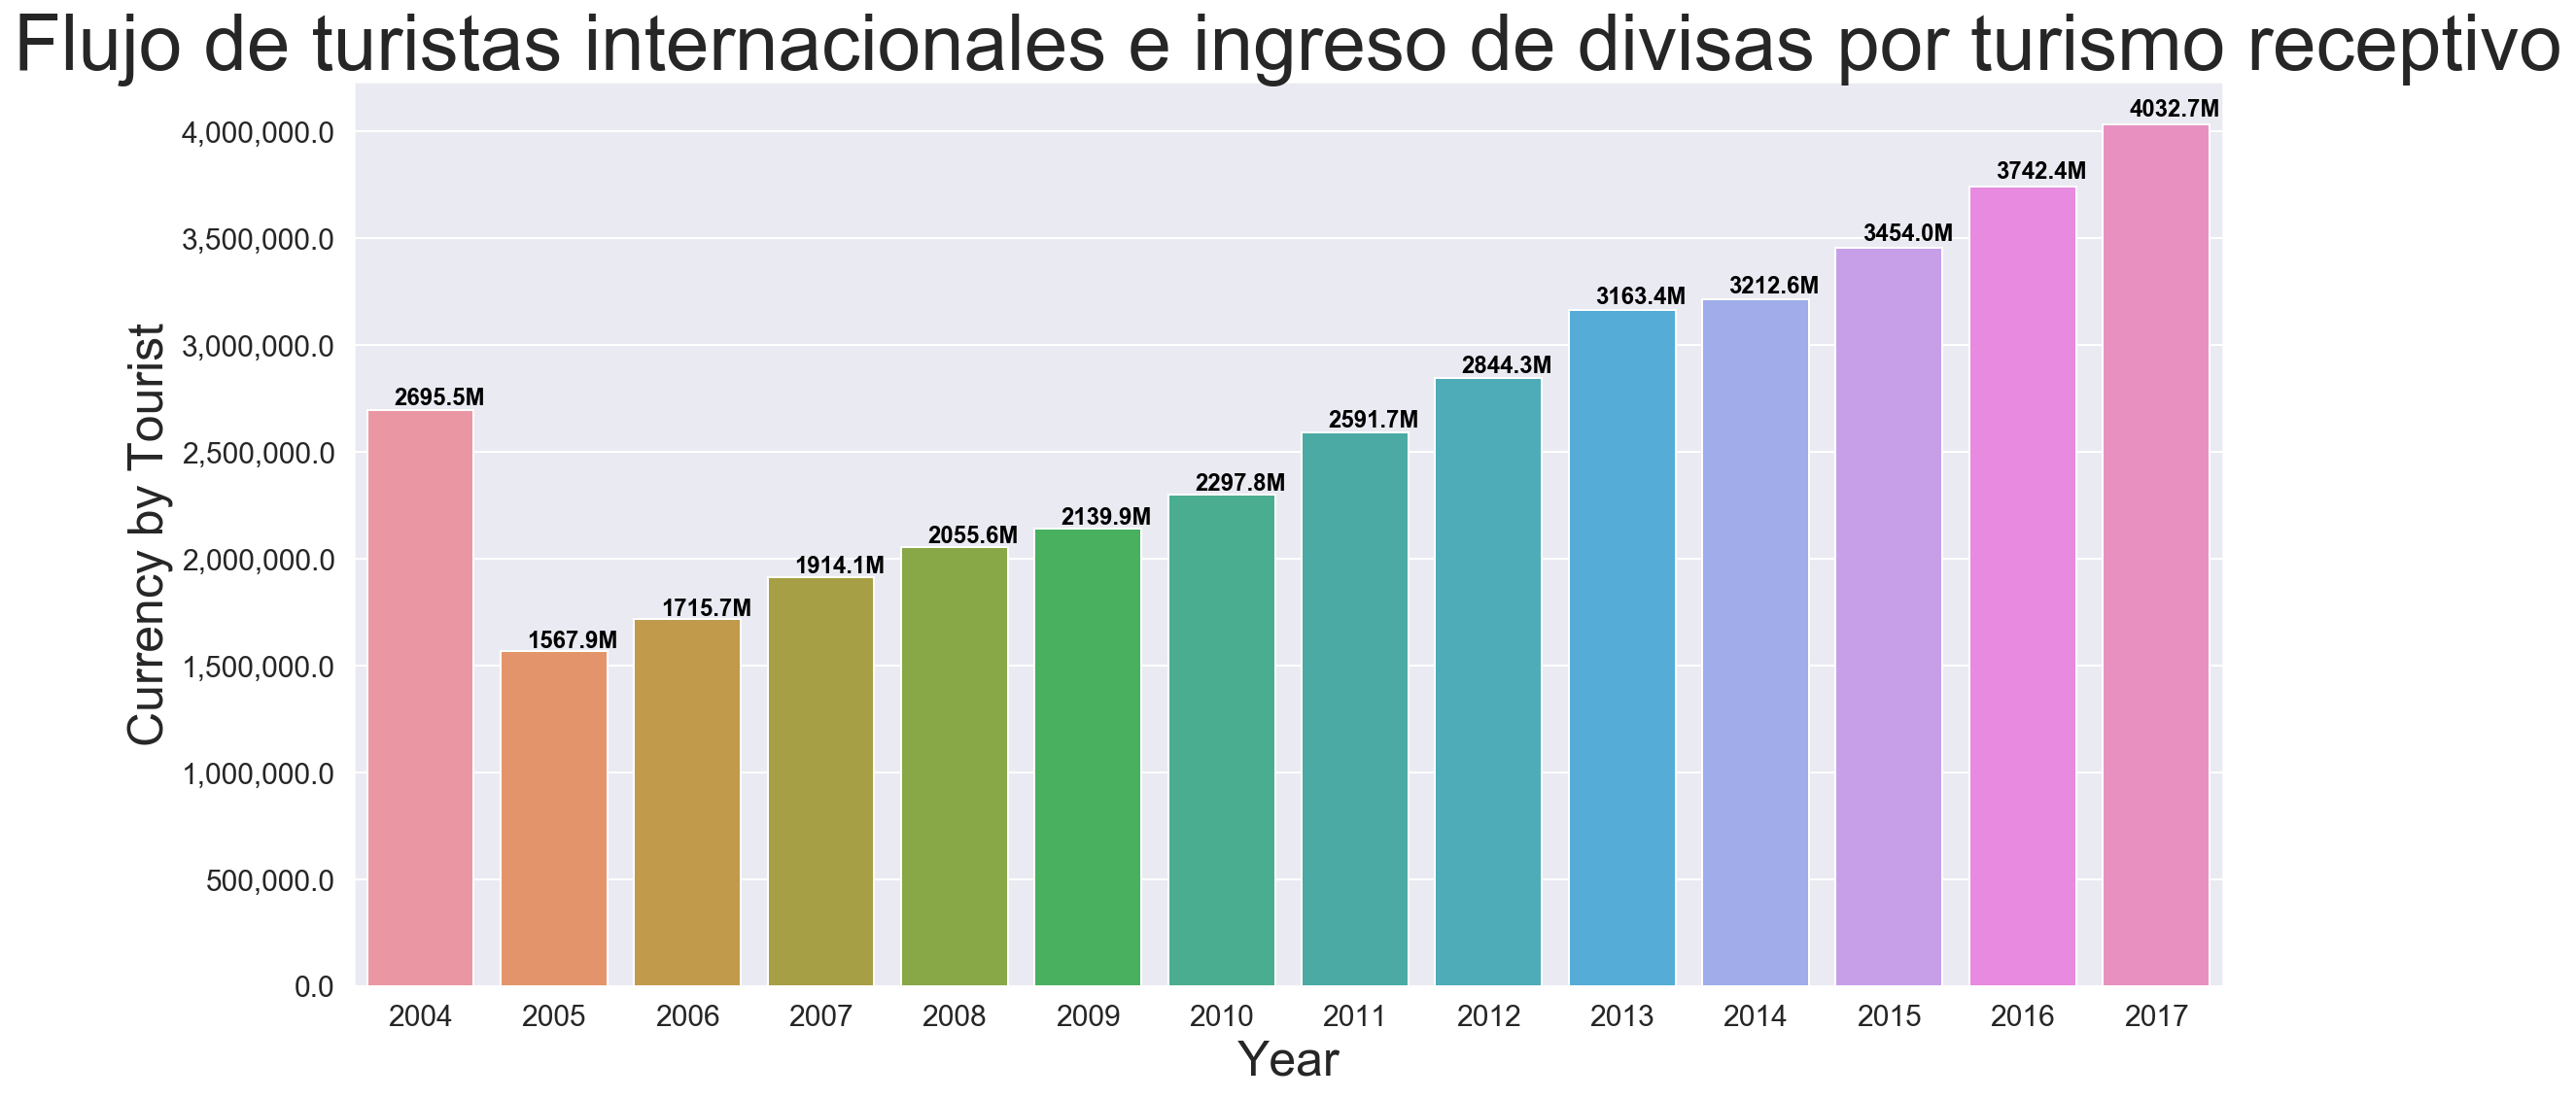

In [163]:
xls_dic = dict(sheet_name='rptaniomes2ps',nrows=72,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Currency by Tourist',)
show_data('llagada_pais.xls',xls_dic,plt_dic,drop=2,
        title='Flujo de turistas internacionales e ingreso de divisas por turismo receptivo')

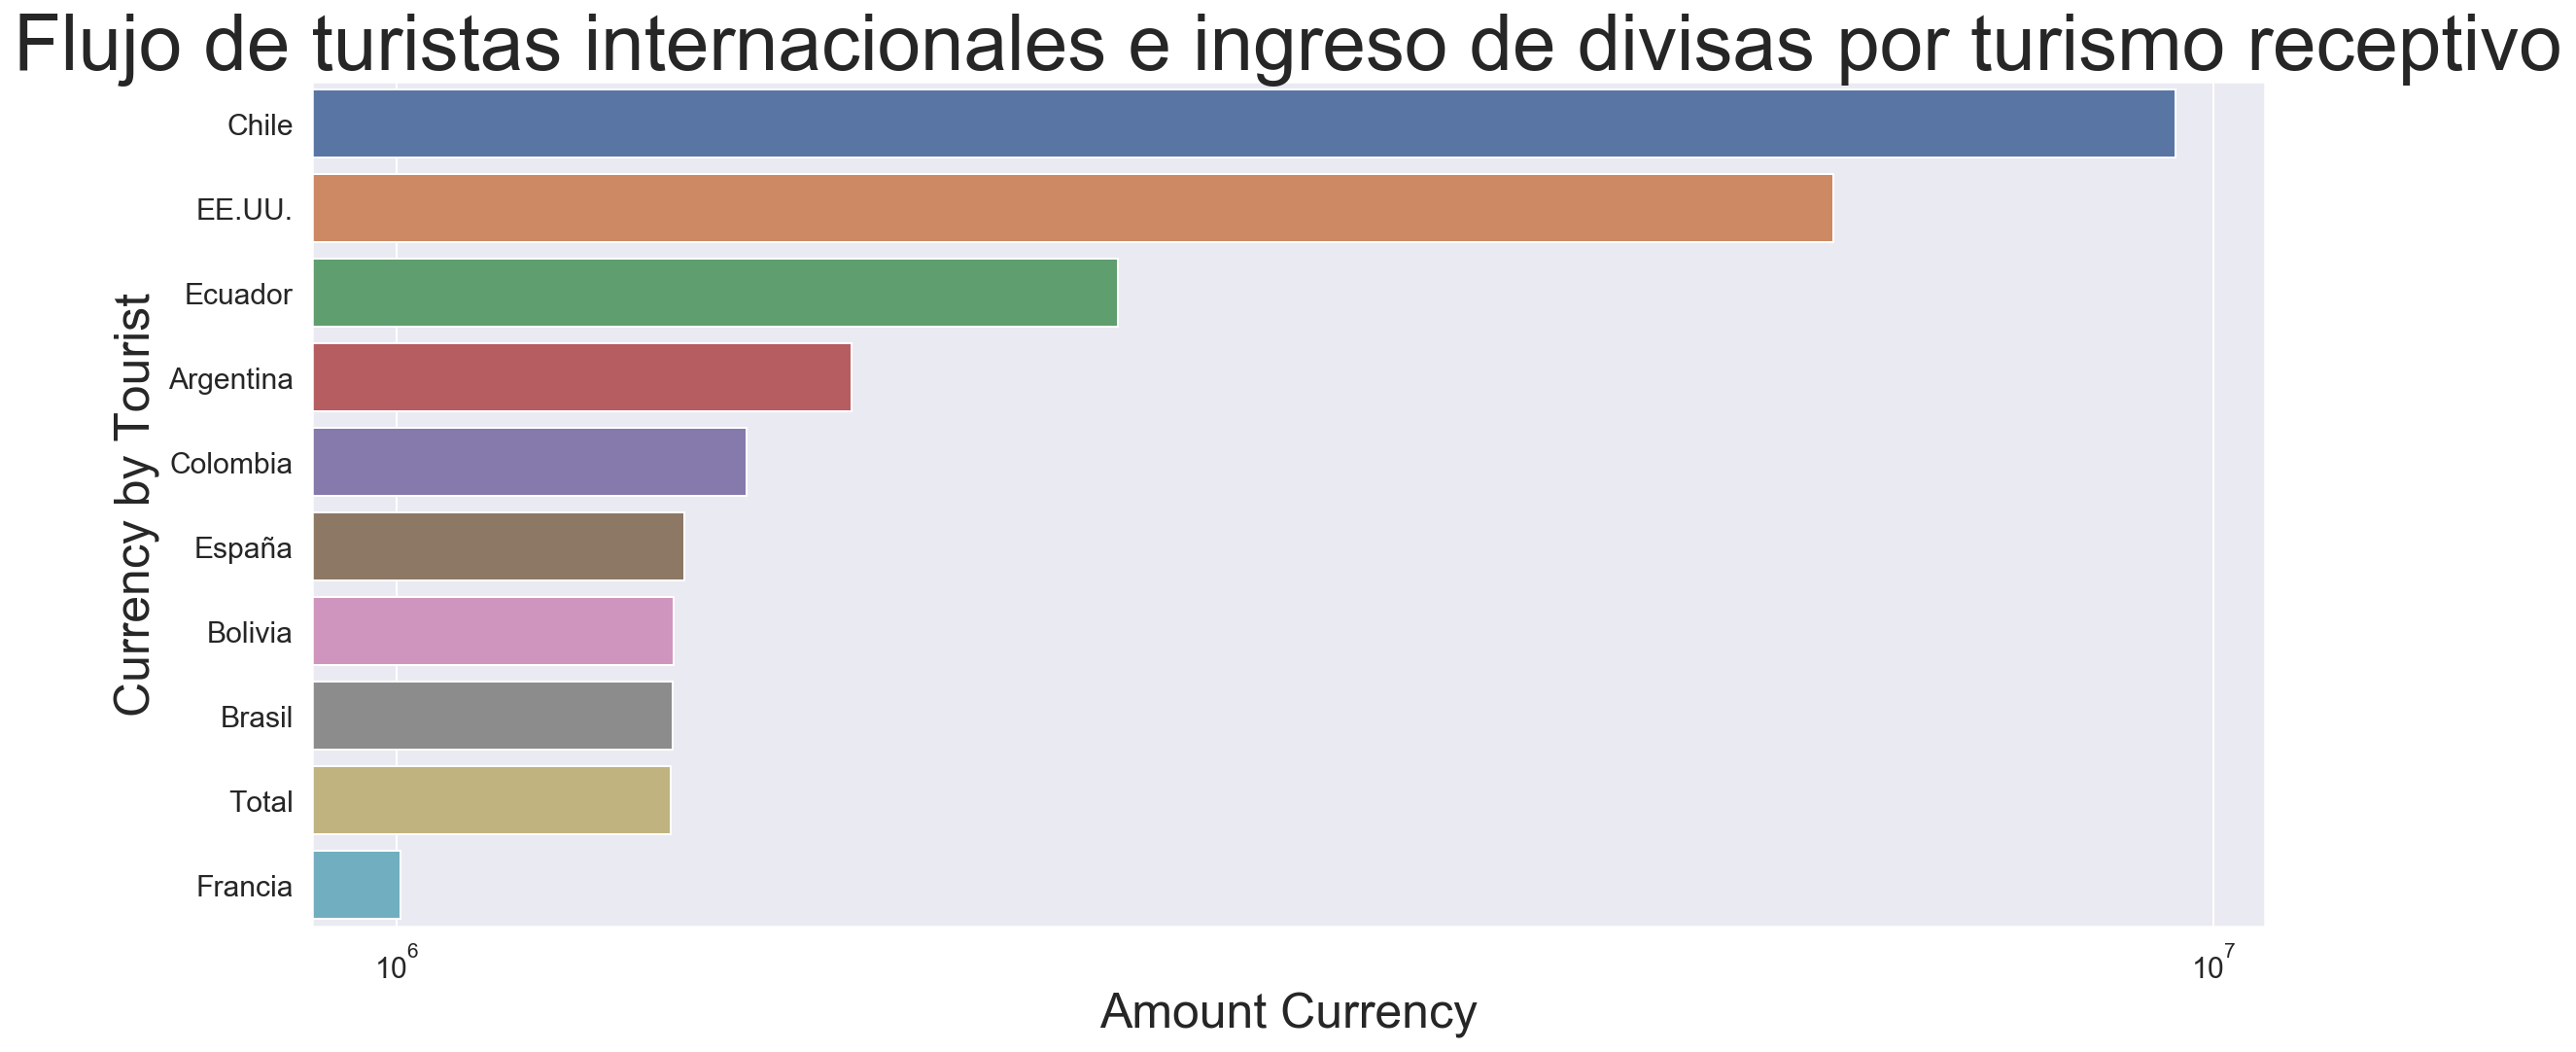

In [164]:
plt_dic = dict(y_label='Currency by Tourist',x_label='Amount Currency',scale='log')
show_by('llagada_pais.xls',xls_dic,plt_dic,
             title='Flujo de turistas internacionales e ingreso de divisas por turismo receptivo')

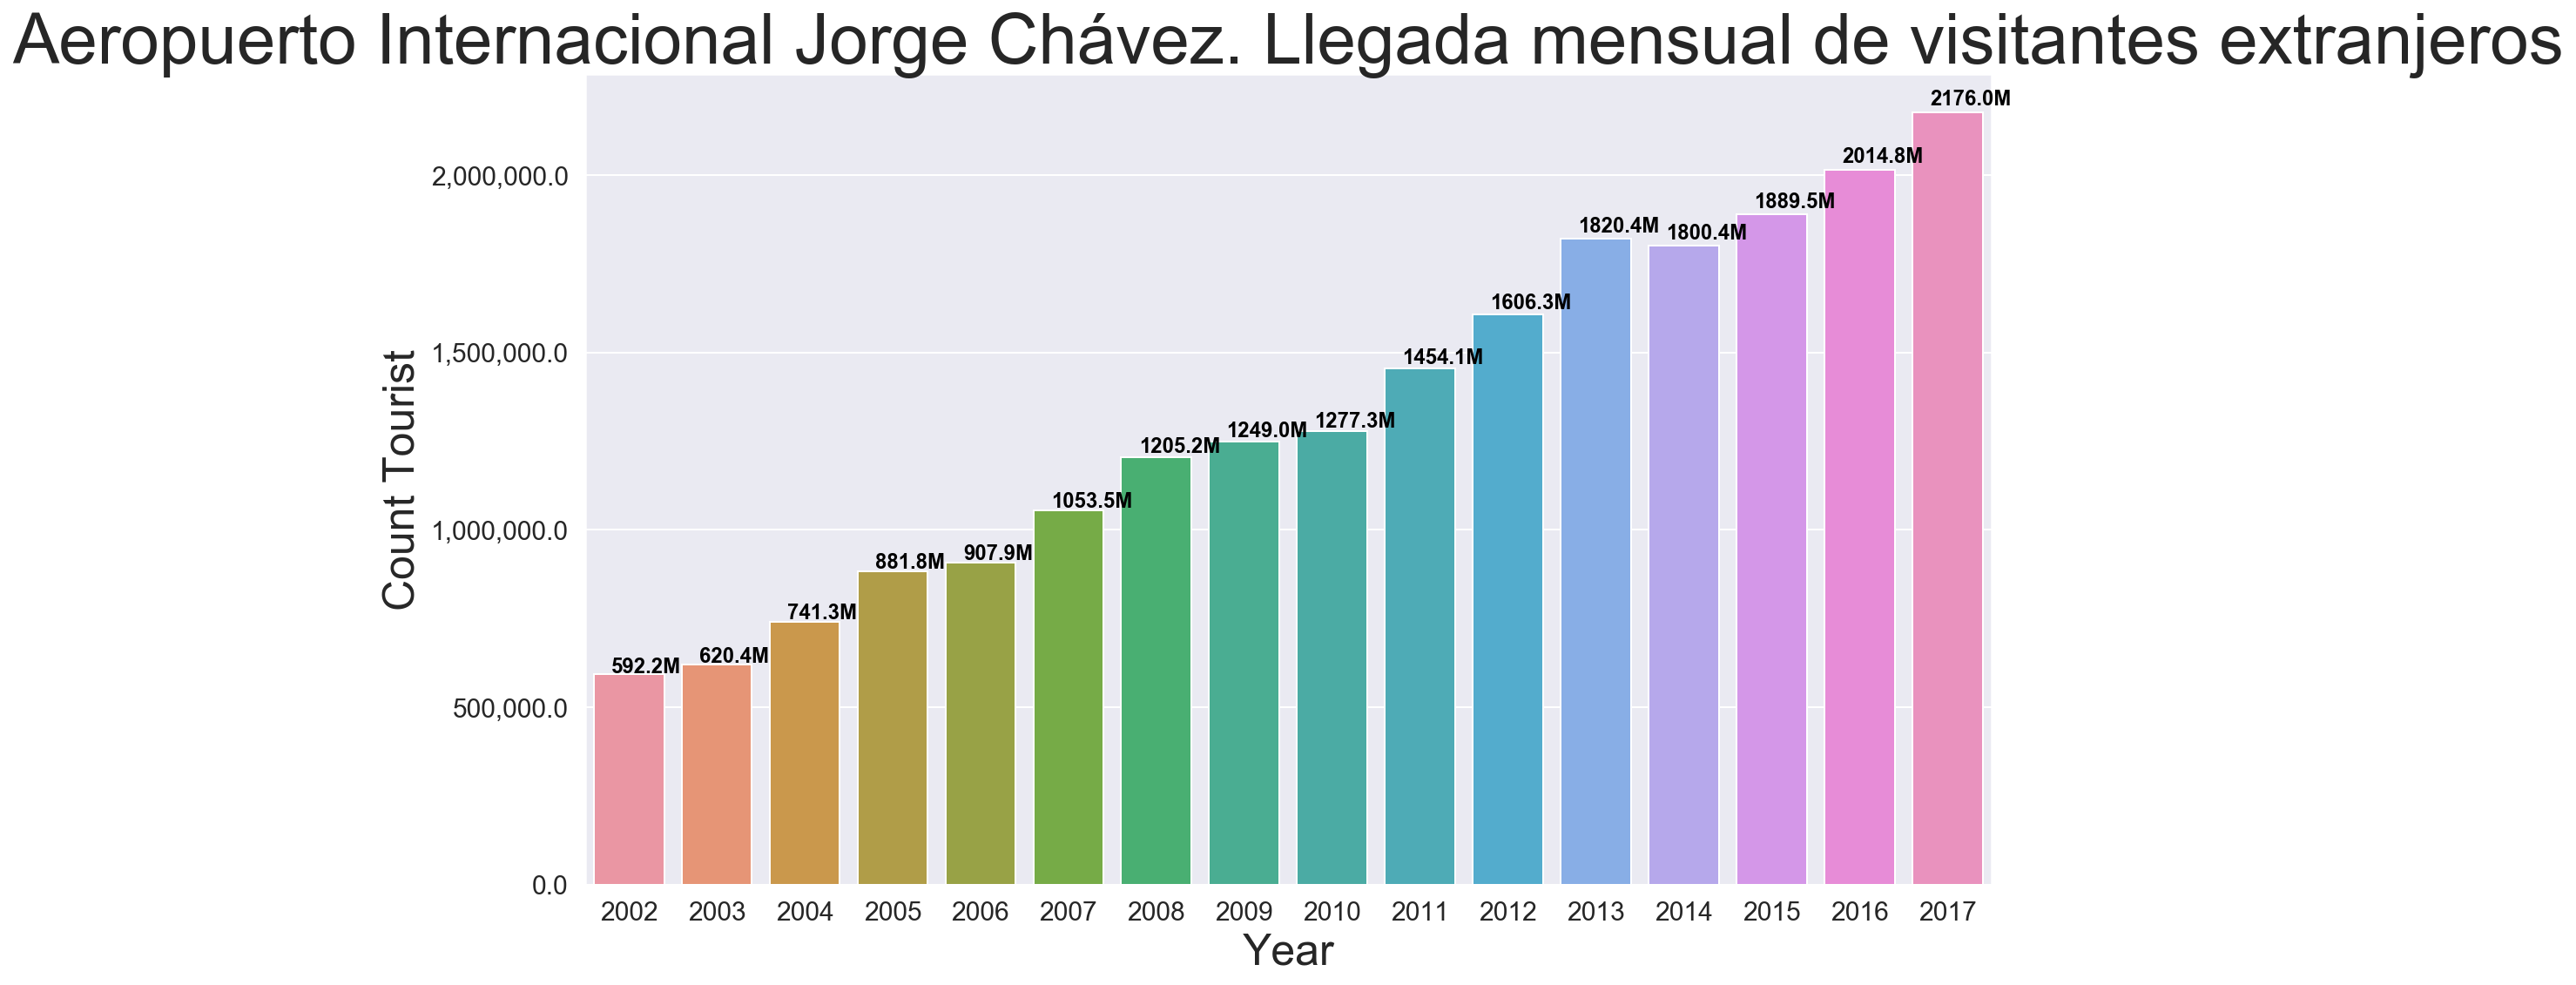

In [165]:
xls_dic = dict(sheet_name='rptaniomes',nrows=12,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Count Tourist',)
show_data('llegada_aeropuerto.xls',xls_dic,plt_dic,drop=0,
        title='Aeropuerto Internacional Jorge Chávez. Llegada mensual de visitantes extranjeros')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2964      0.170      1.741      0.082      -0.037       0.630
ma.L1         -0.6751      0.127     -5.310      0.000      -0.924      -0.426
ar.S.L12      -0.4194      0.096     -4.378      0.000      -0.607      -0.232
sigma2      3.265e+07   2.16e-09   1.51e+16      0.000    3.26e+07    3.26e+07


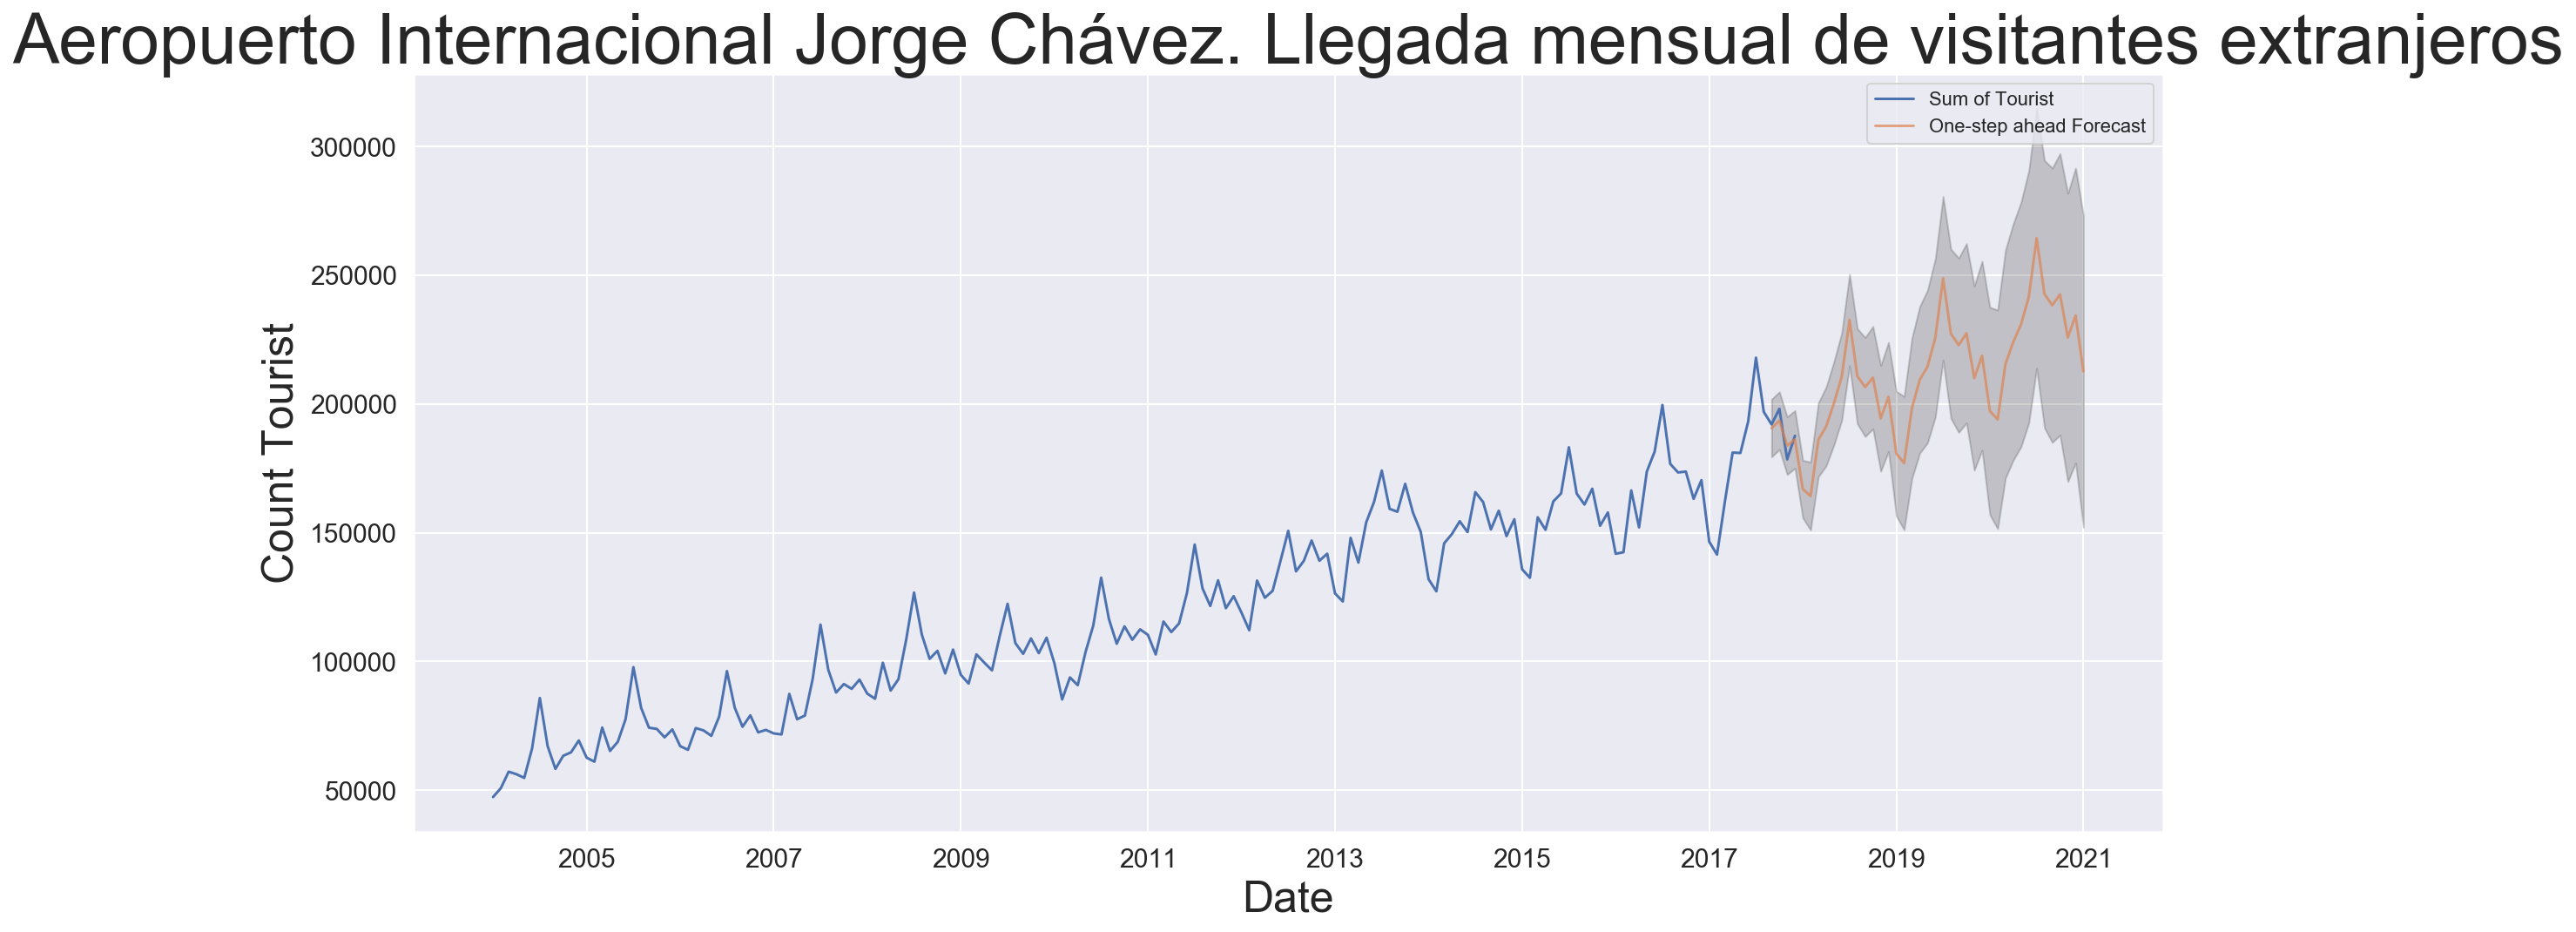

In [166]:
predict_plot('llegada_aeropuerto.xls',xls_dic,
             title='Aeropuerto Internacional Jorge Chávez. Llegada mensual de visitantes extranjeros')

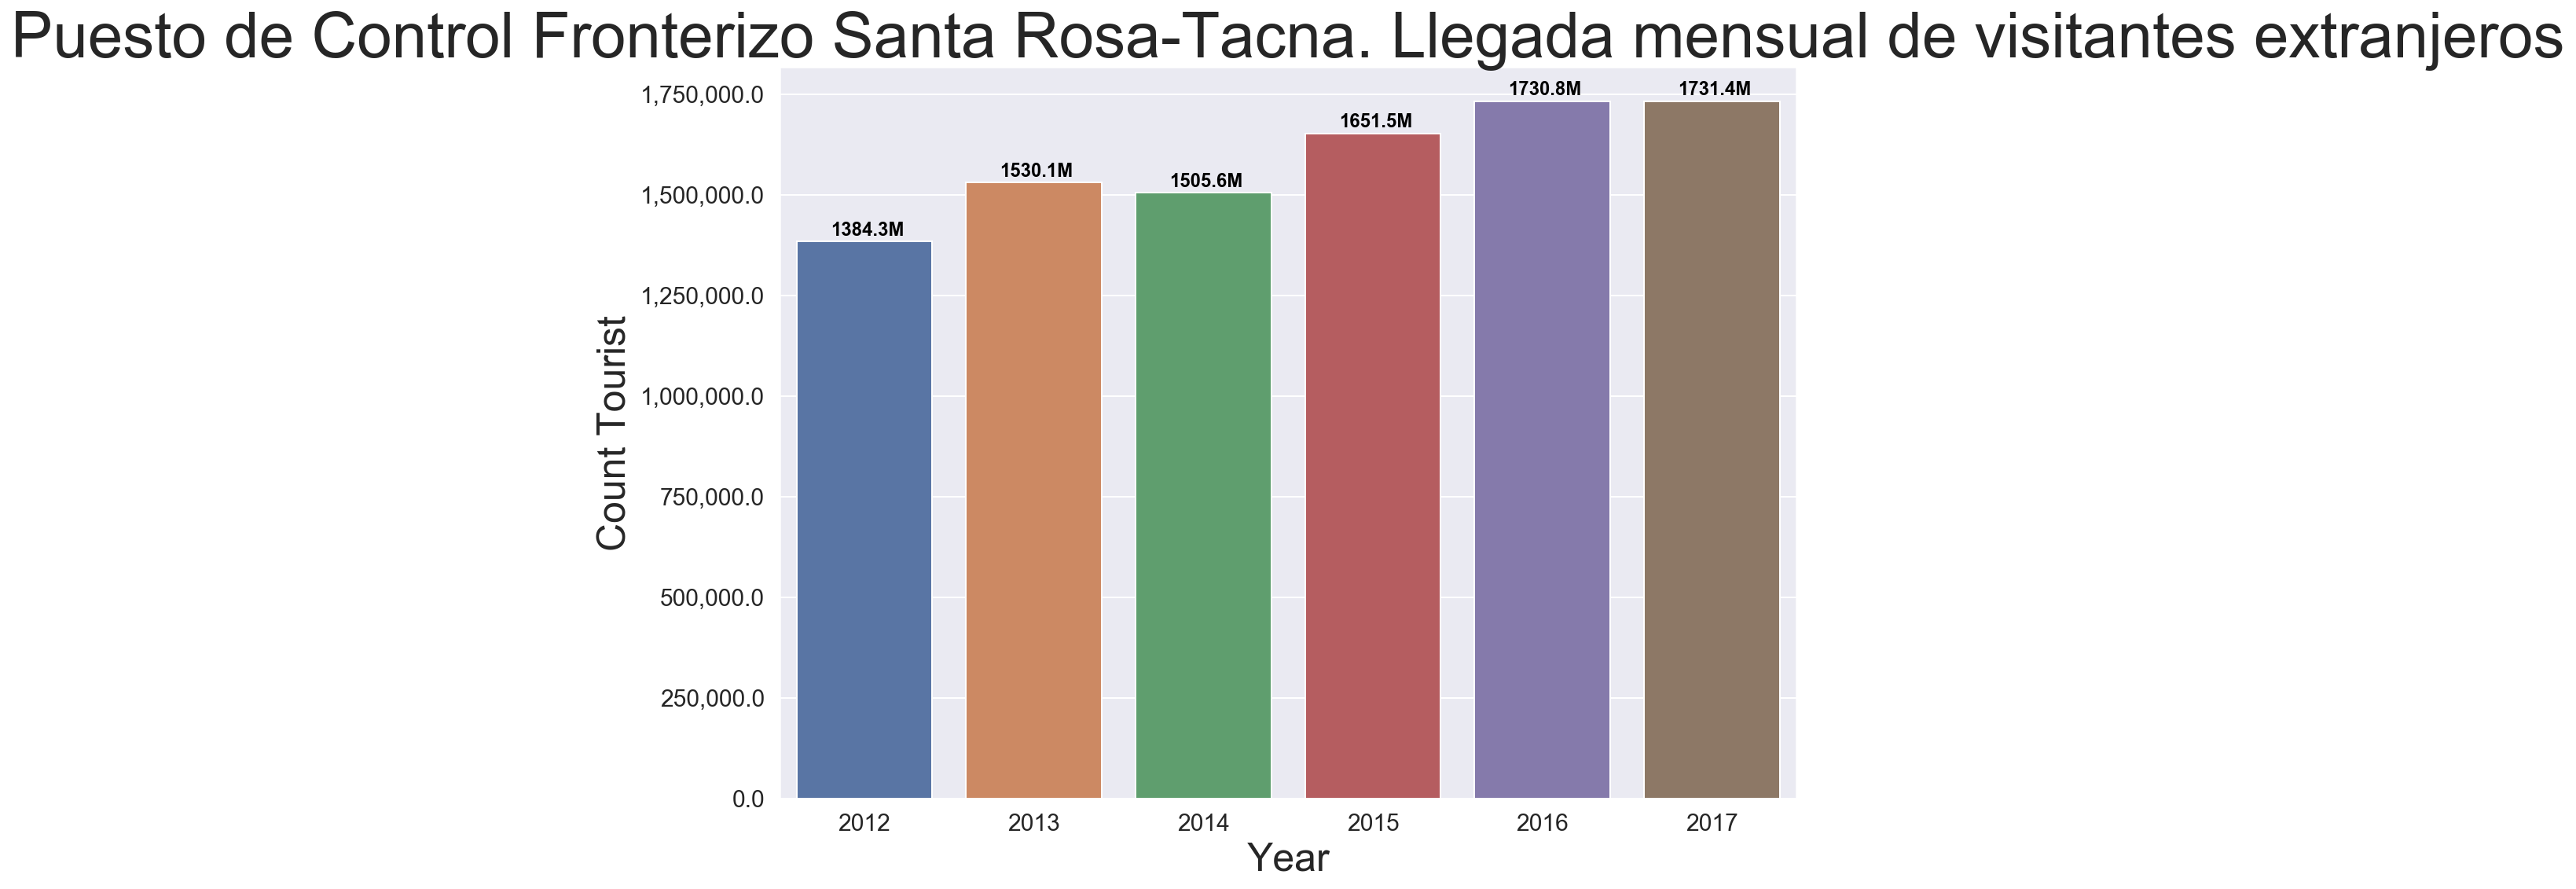

In [167]:
xls_dic = dict(sheet_name='rptaniomes',nrows=12,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Count Tourist',)
show_data('llegada_control_fronterizo.xls',xls_dic,plt_dic,drop=0,
        title='Puesto de Control Fronterizo Santa Rosa-Tacna. Llegada mensual de visitantes extranjeros')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3056      0.453     -0.674      0.500      -1.194       0.583
ma.L1         -0.7783      0.231     -3.370      0.001      -1.231      -0.326
ar.S.L12      -0.2066      0.191     -1.080      0.280      -0.582       0.168
sigma2      2.686e+08   6.12e-10   4.39e+17      0.000    2.69e+08    2.69e+08


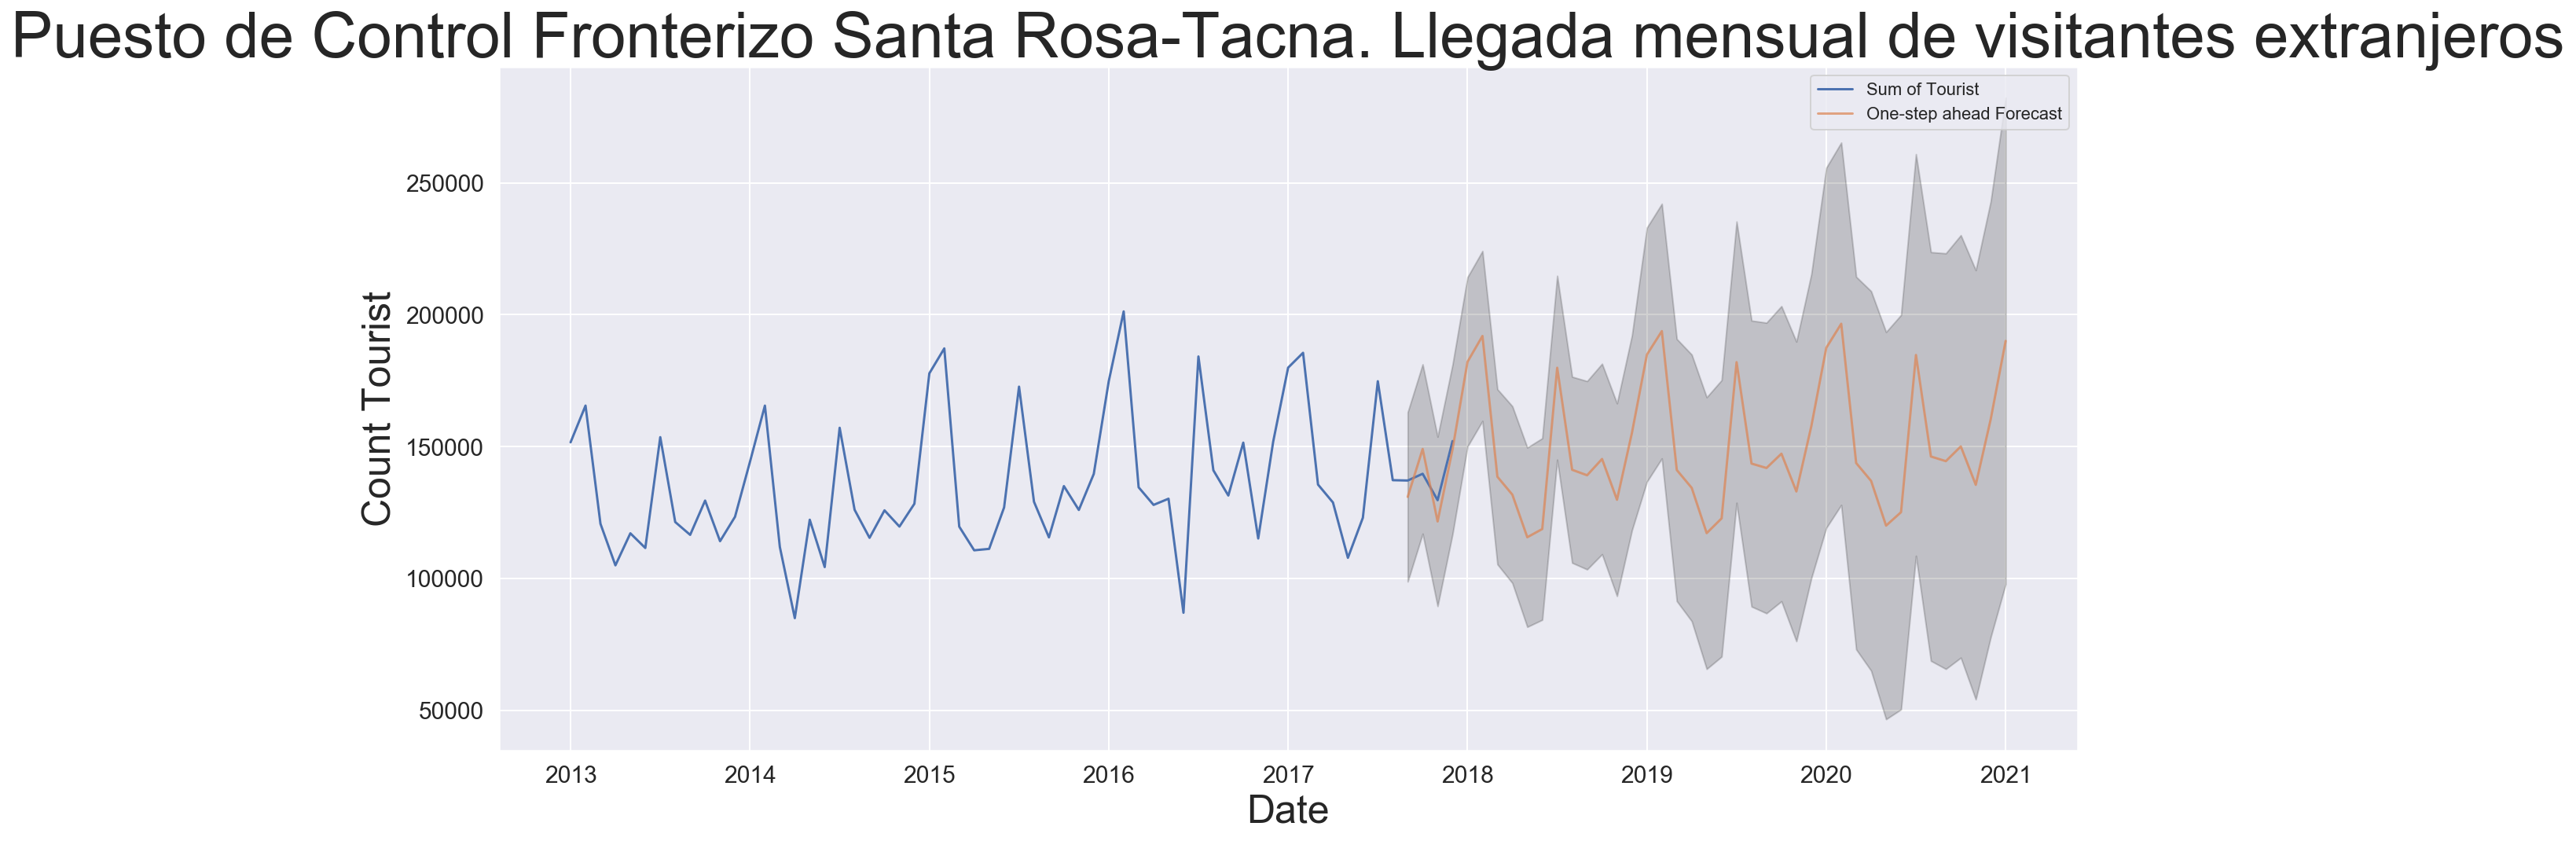

In [168]:
predict_plot('llegada_control_fronterizo.xls',xls_dic,
             title='Puesto de Control Fronterizo Santa Rosa-Tacna. Llegada mensual de visitantes extranjeros')

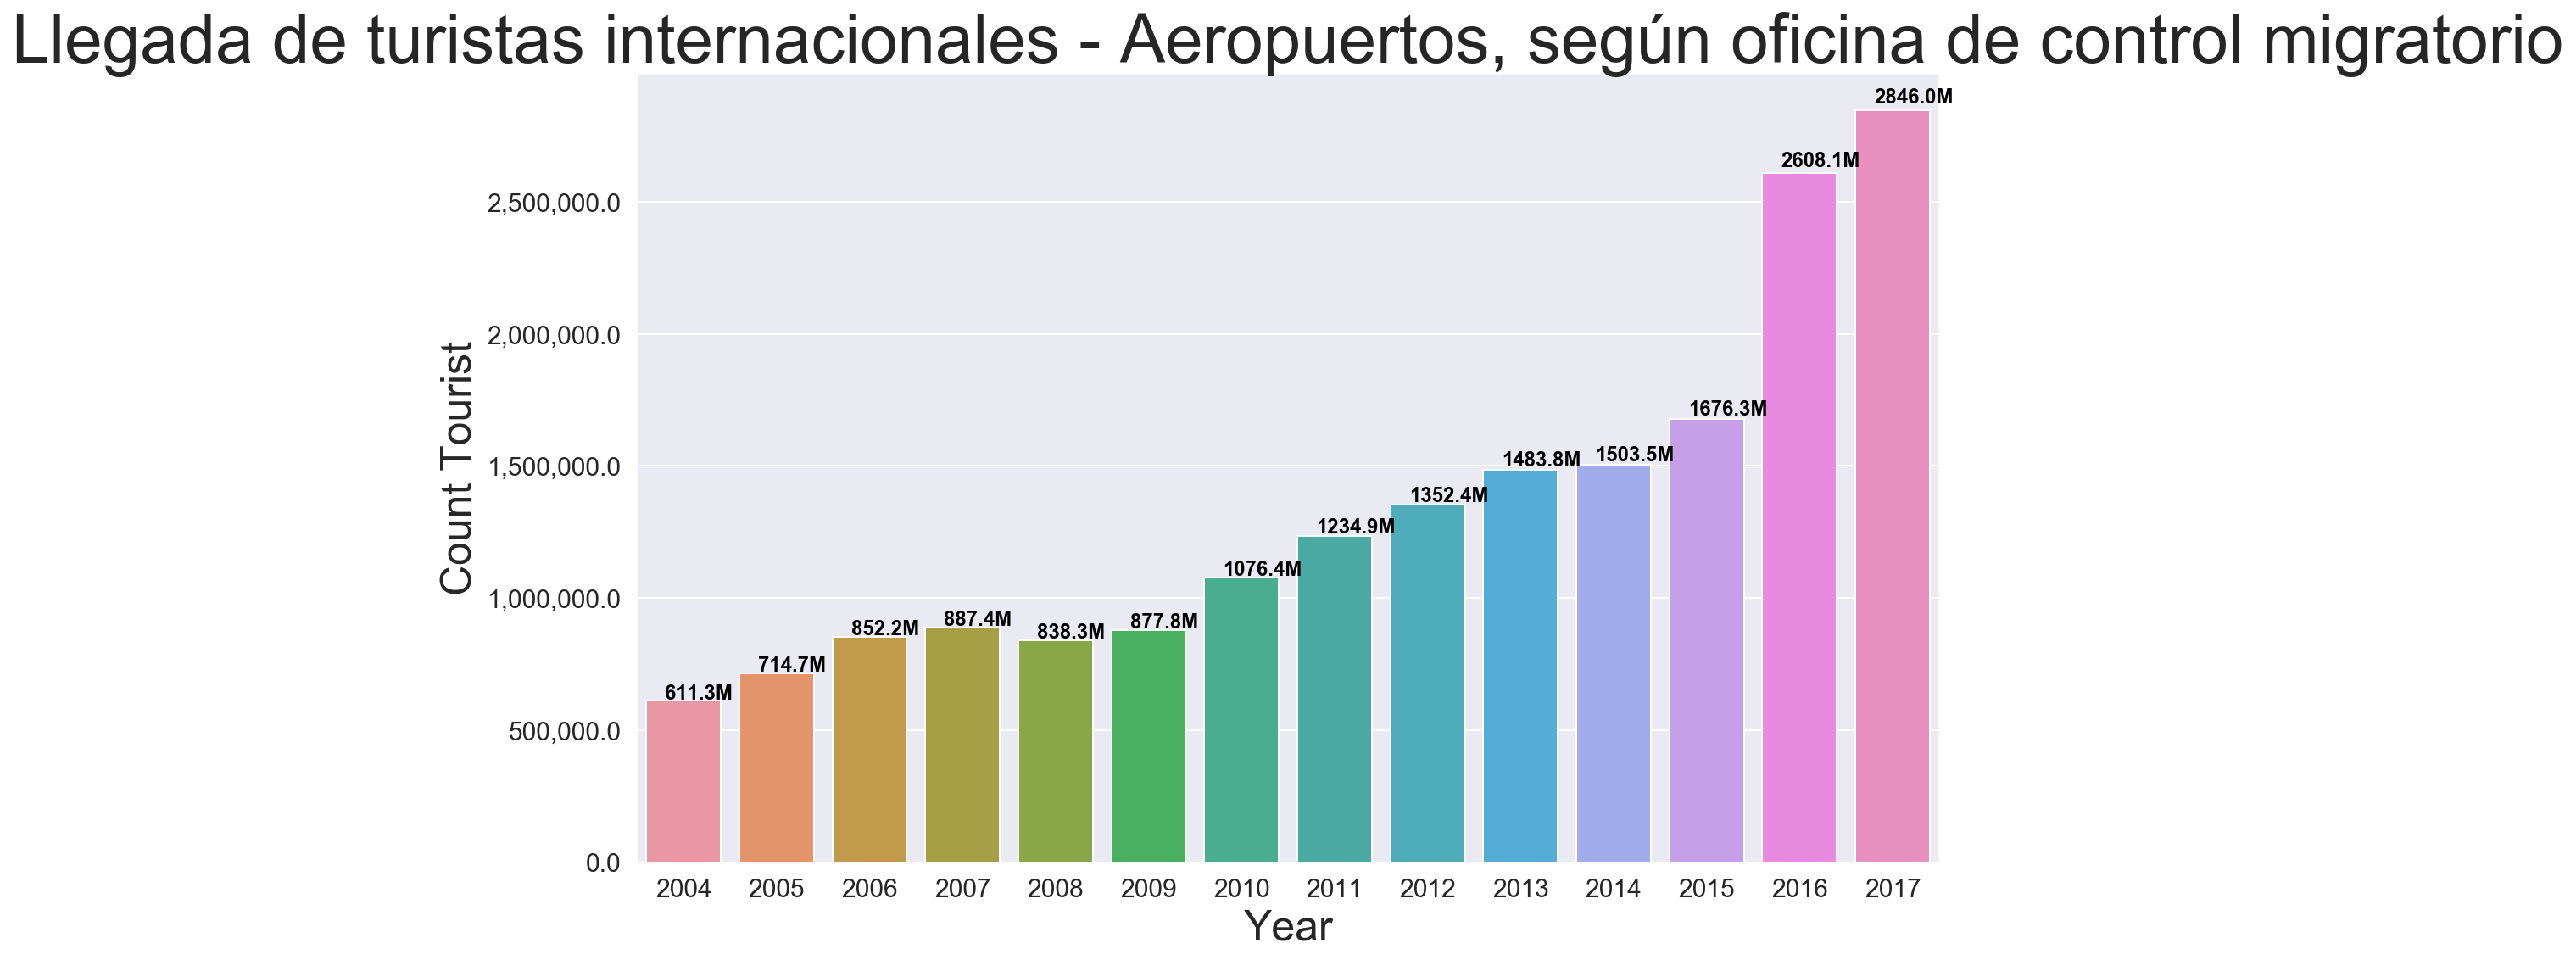

In [169]:
xls_dic = dict(sheet_name='rptaniomes2_OCM',nrows=12,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Count Tourist',)
show_data('llegada_imigraciones.xls',xls_dic,plt_dic,drop=2,
        title='Llegada de turistas internacionales - Aeropuertos, según oficina de control migratorio')

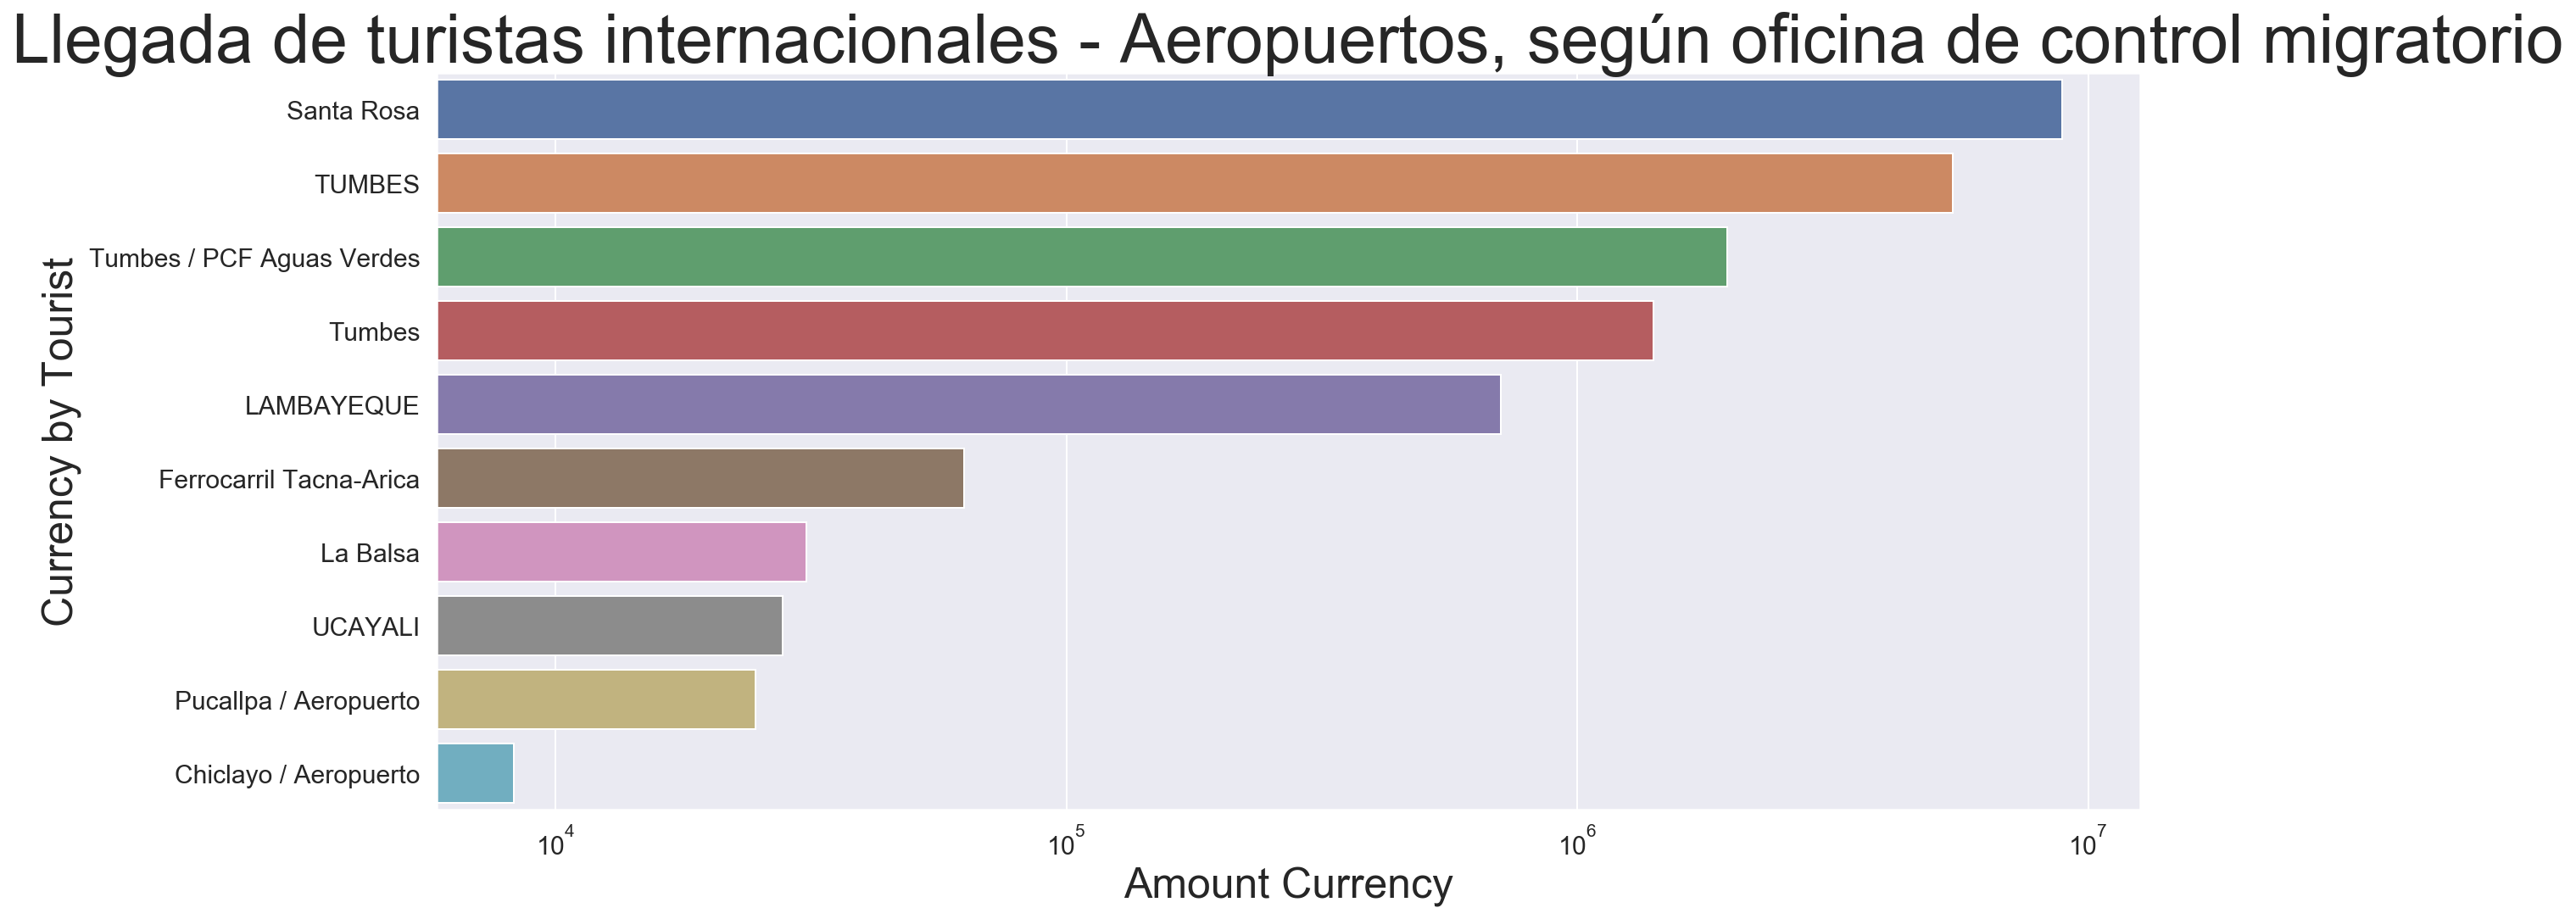

In [170]:
plt_dic = dict(y_label='Currency by Tourist',x_label='Amount Currency',scale='log')
show_by('llegada_imigraciones.xls',xls_dic,plt_dic,
             title='Llegada de turistas internacionales - Aeropuertos, según oficina de control migratorio')

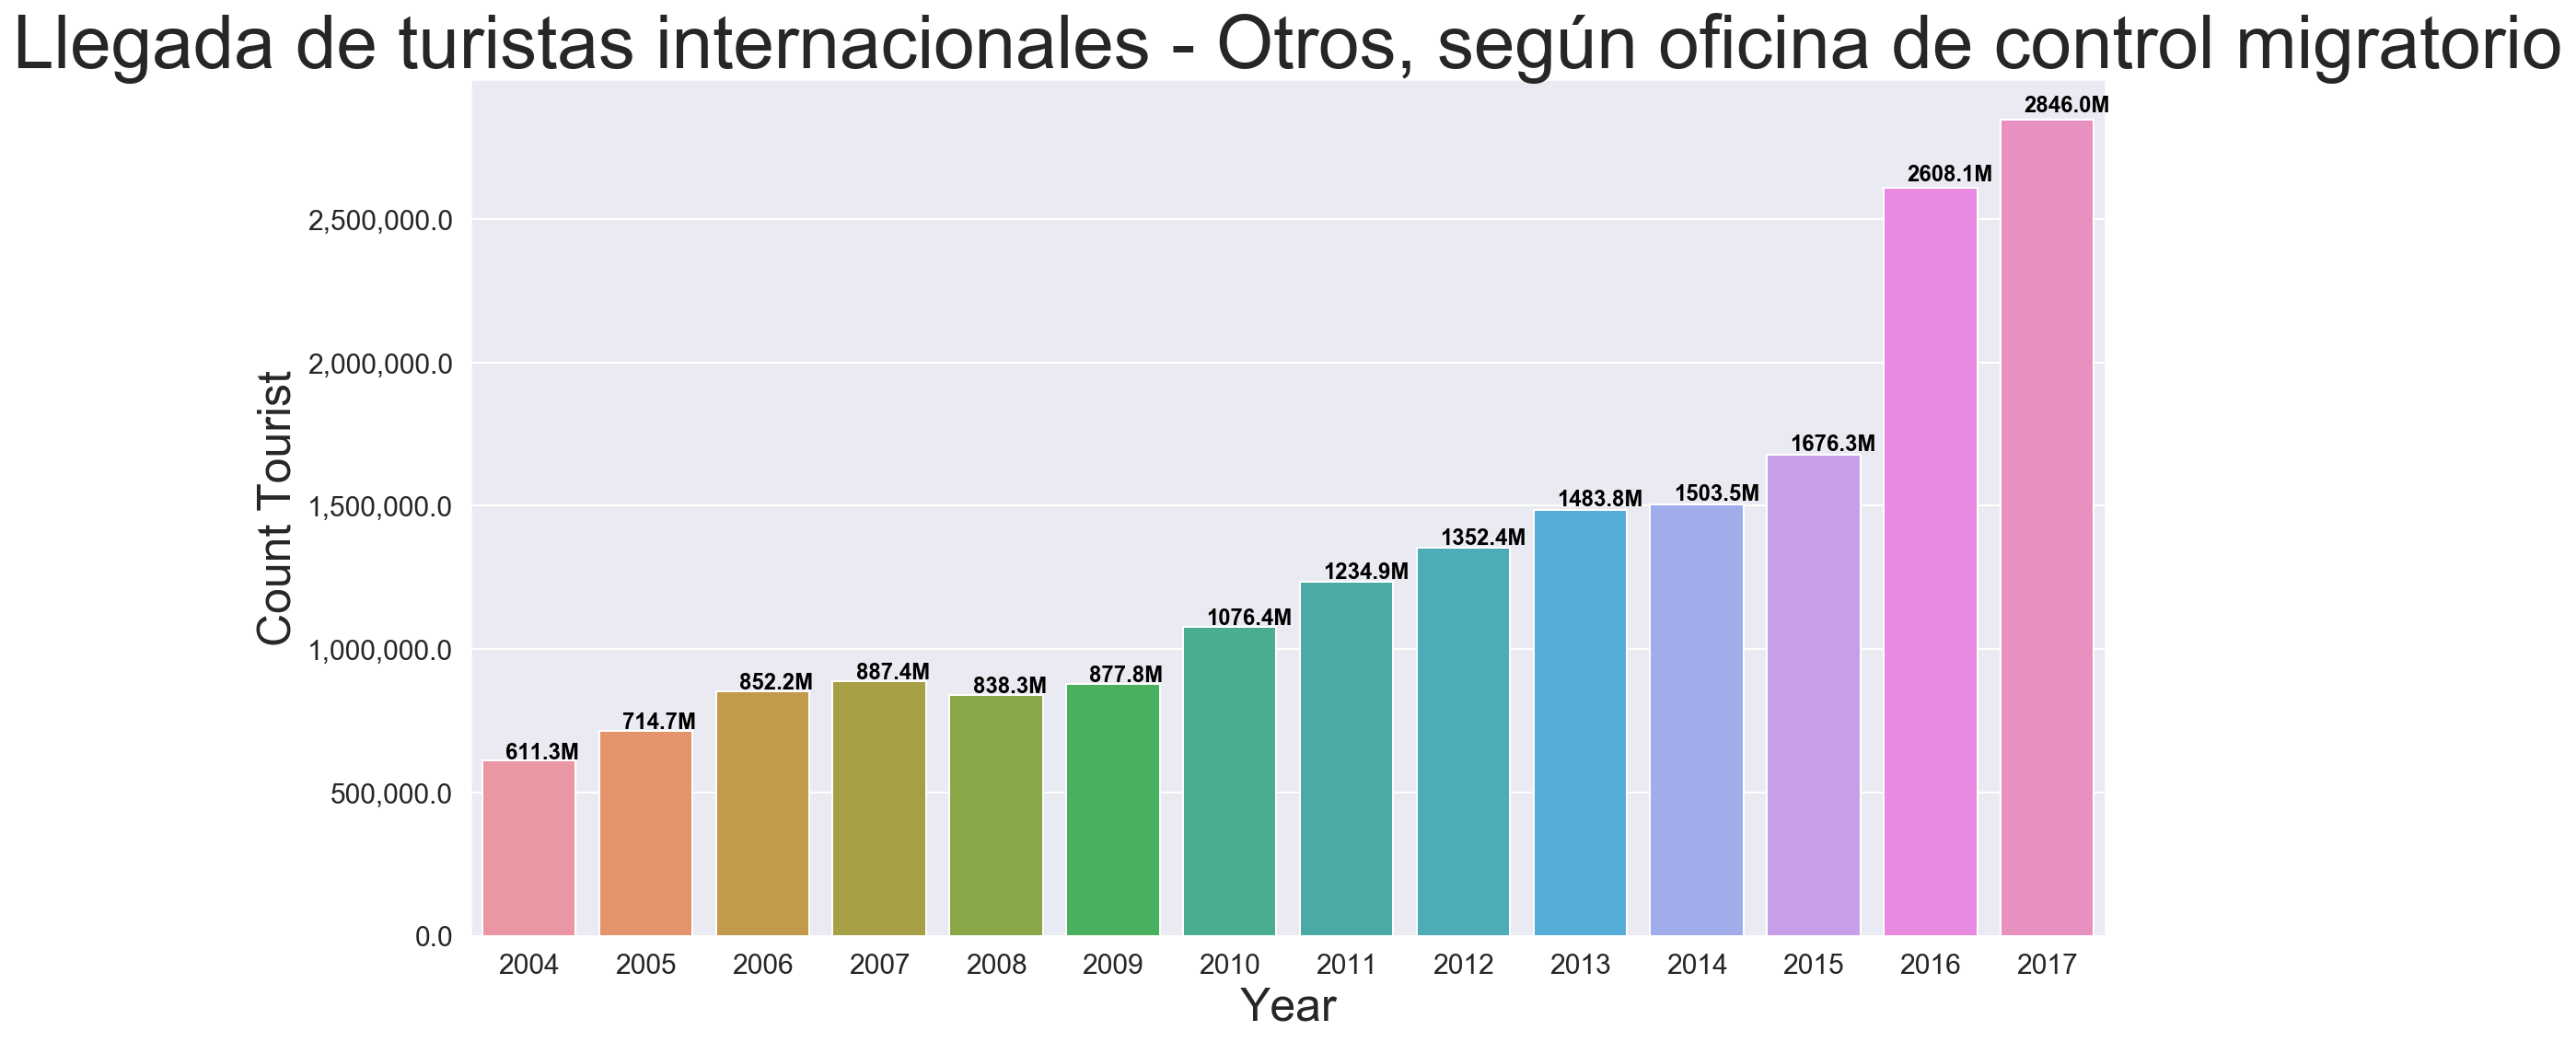

In [171]:
xls_dic = dict(sheet_name='rptaniomes2_OCM',nrows=12,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Count Tourist',)
show_data('llegada_mensual.xls',xls_dic,plt_dic,drop=2,
        title='Llegada de turistas internacionales - Otros, según oficina de control migratorio')

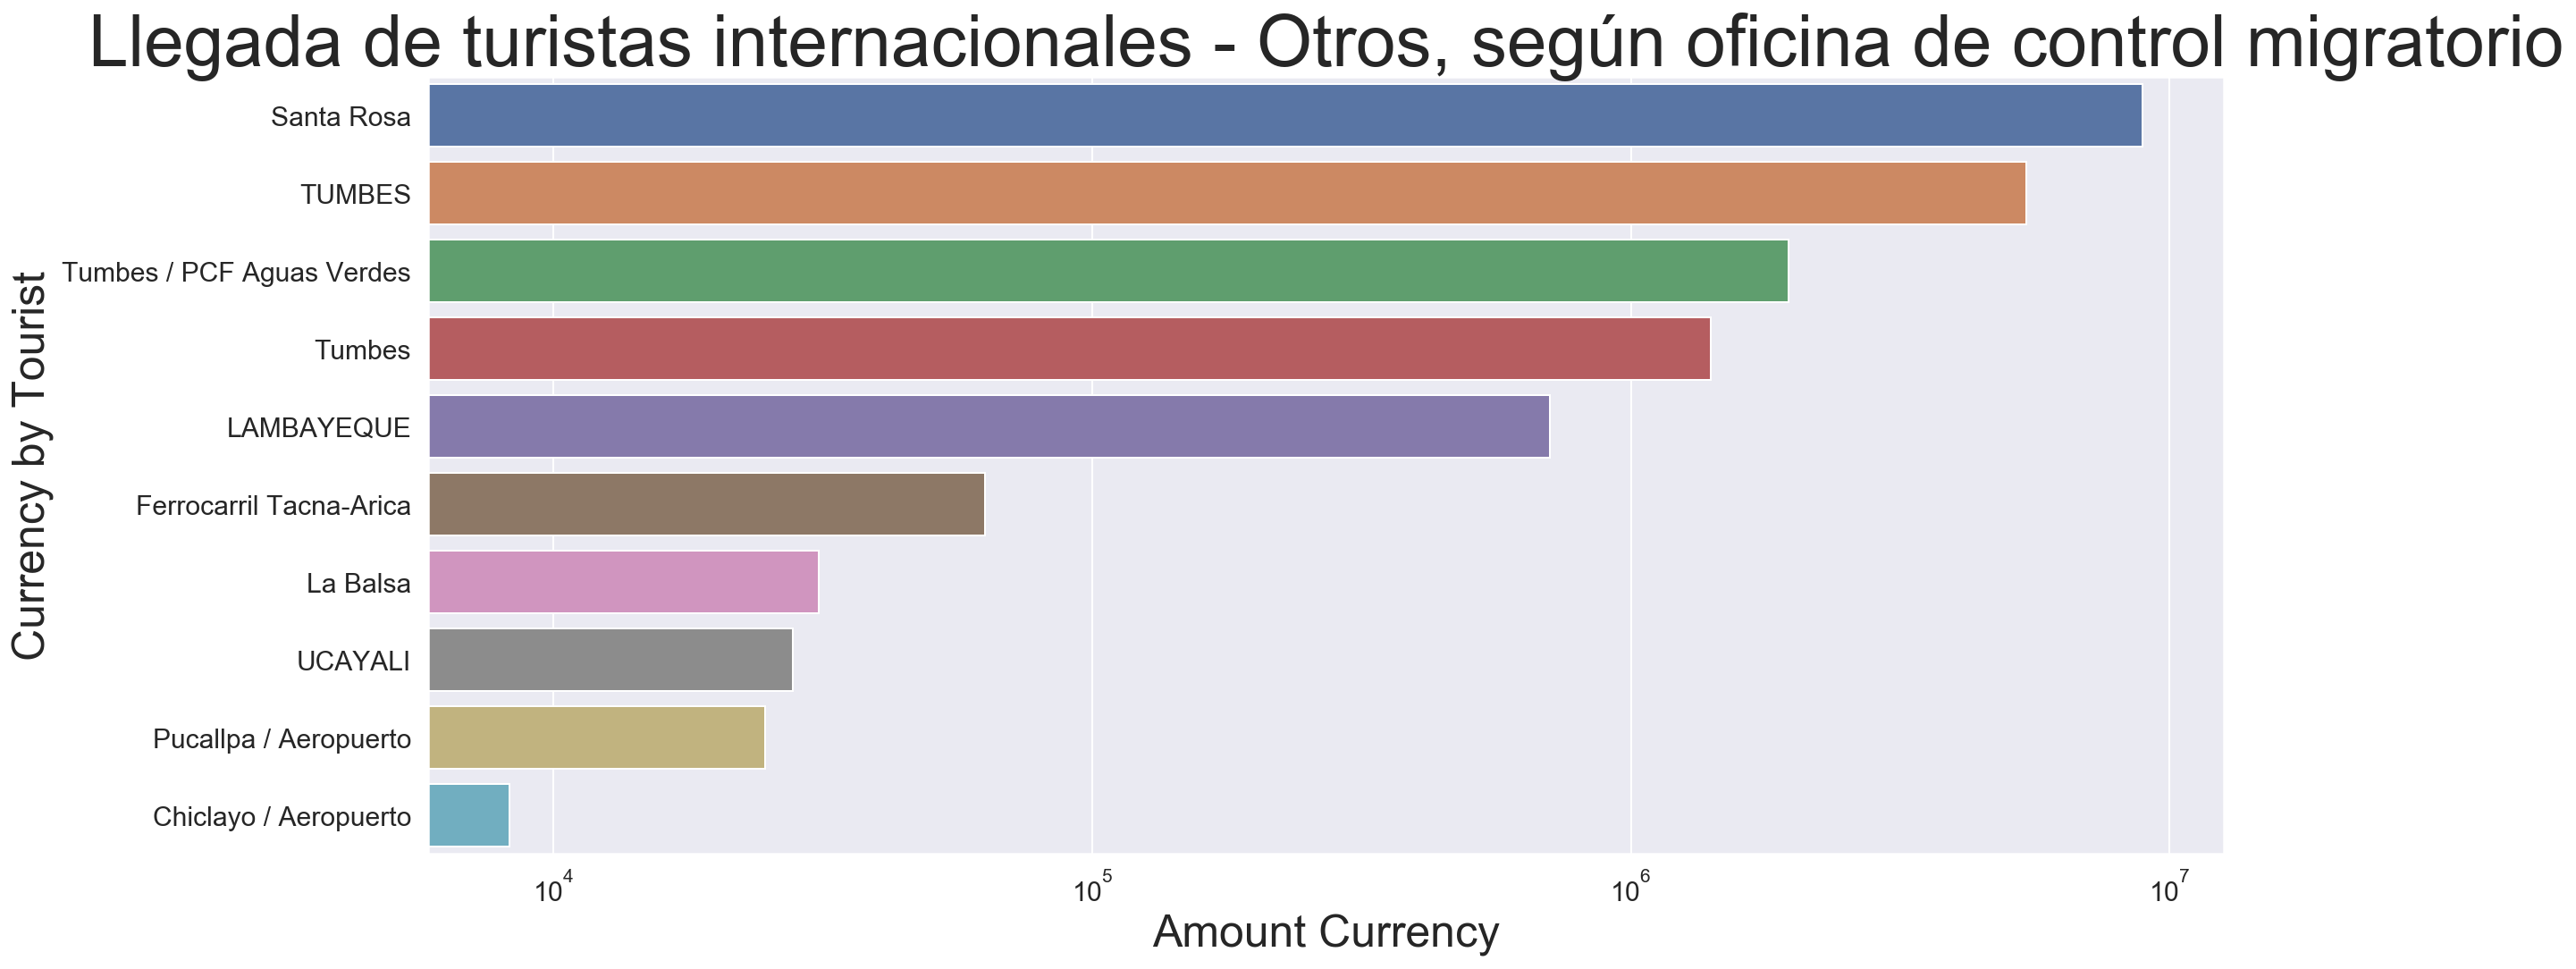

In [172]:
plt_dic = dict(y_label='Currency by Tourist',x_label='Amount Currency',scale='log')
show_by('llegada_mensual.xls',xls_dic, plt_dic,
        title='Llegada de turistas internacionales - Otros, según oficina de control migratorio')

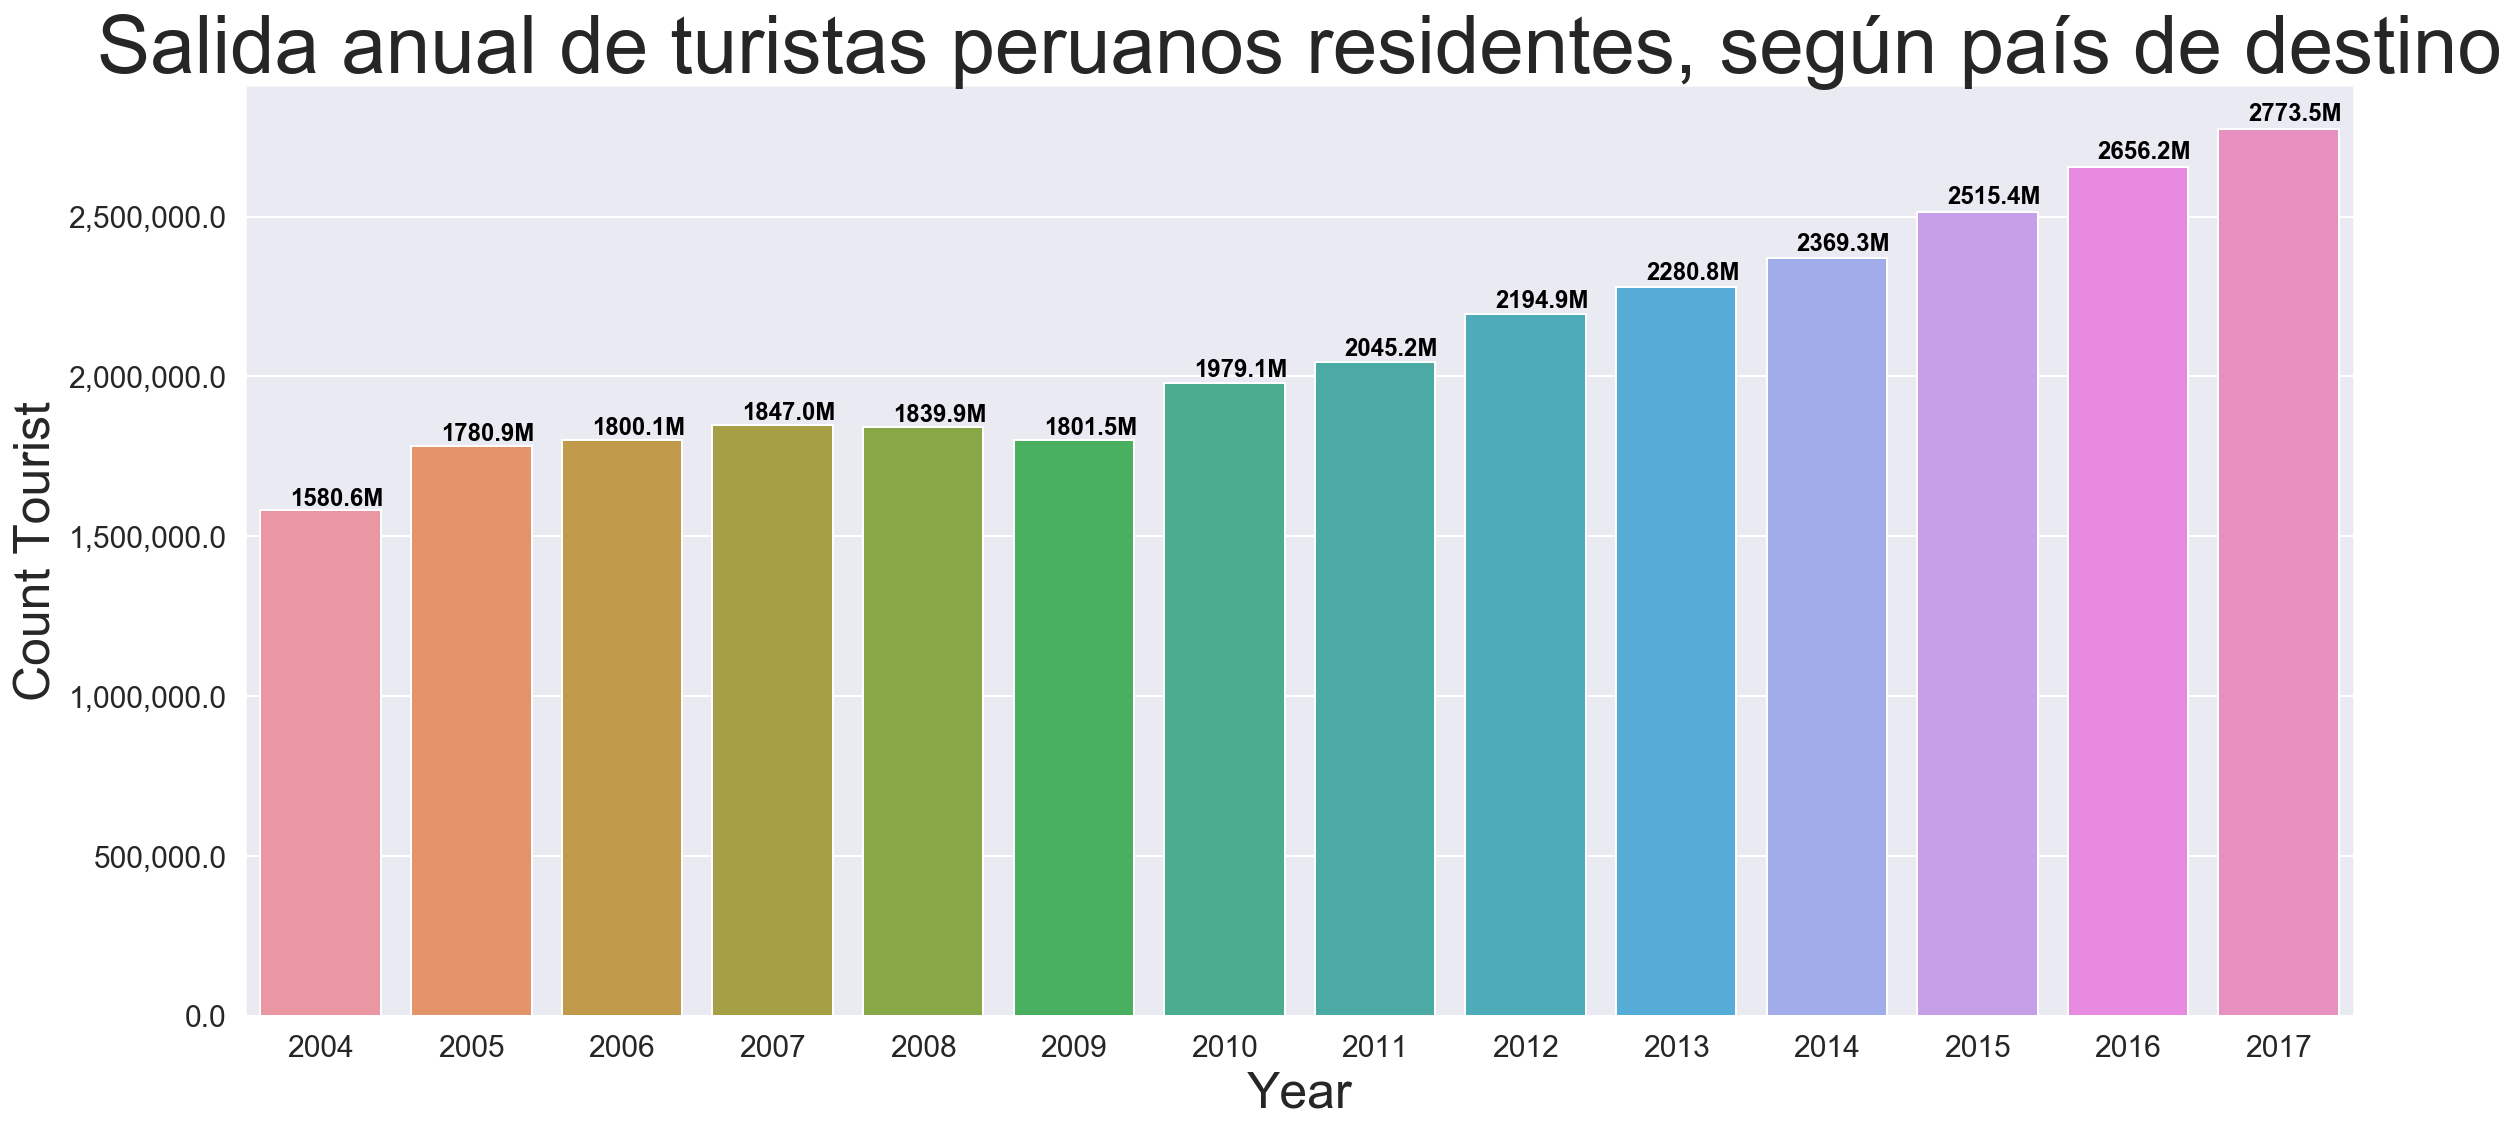

In [173]:
xls_dic = dict(sheet_name='rptaniomes2ps',nrows=12,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Count Tourist',)
show_data('salida_pais.xls',xls_dic,plt_dic,drop=2,
        title='Salida anual de turistas peruanos residentes, según país de destino')

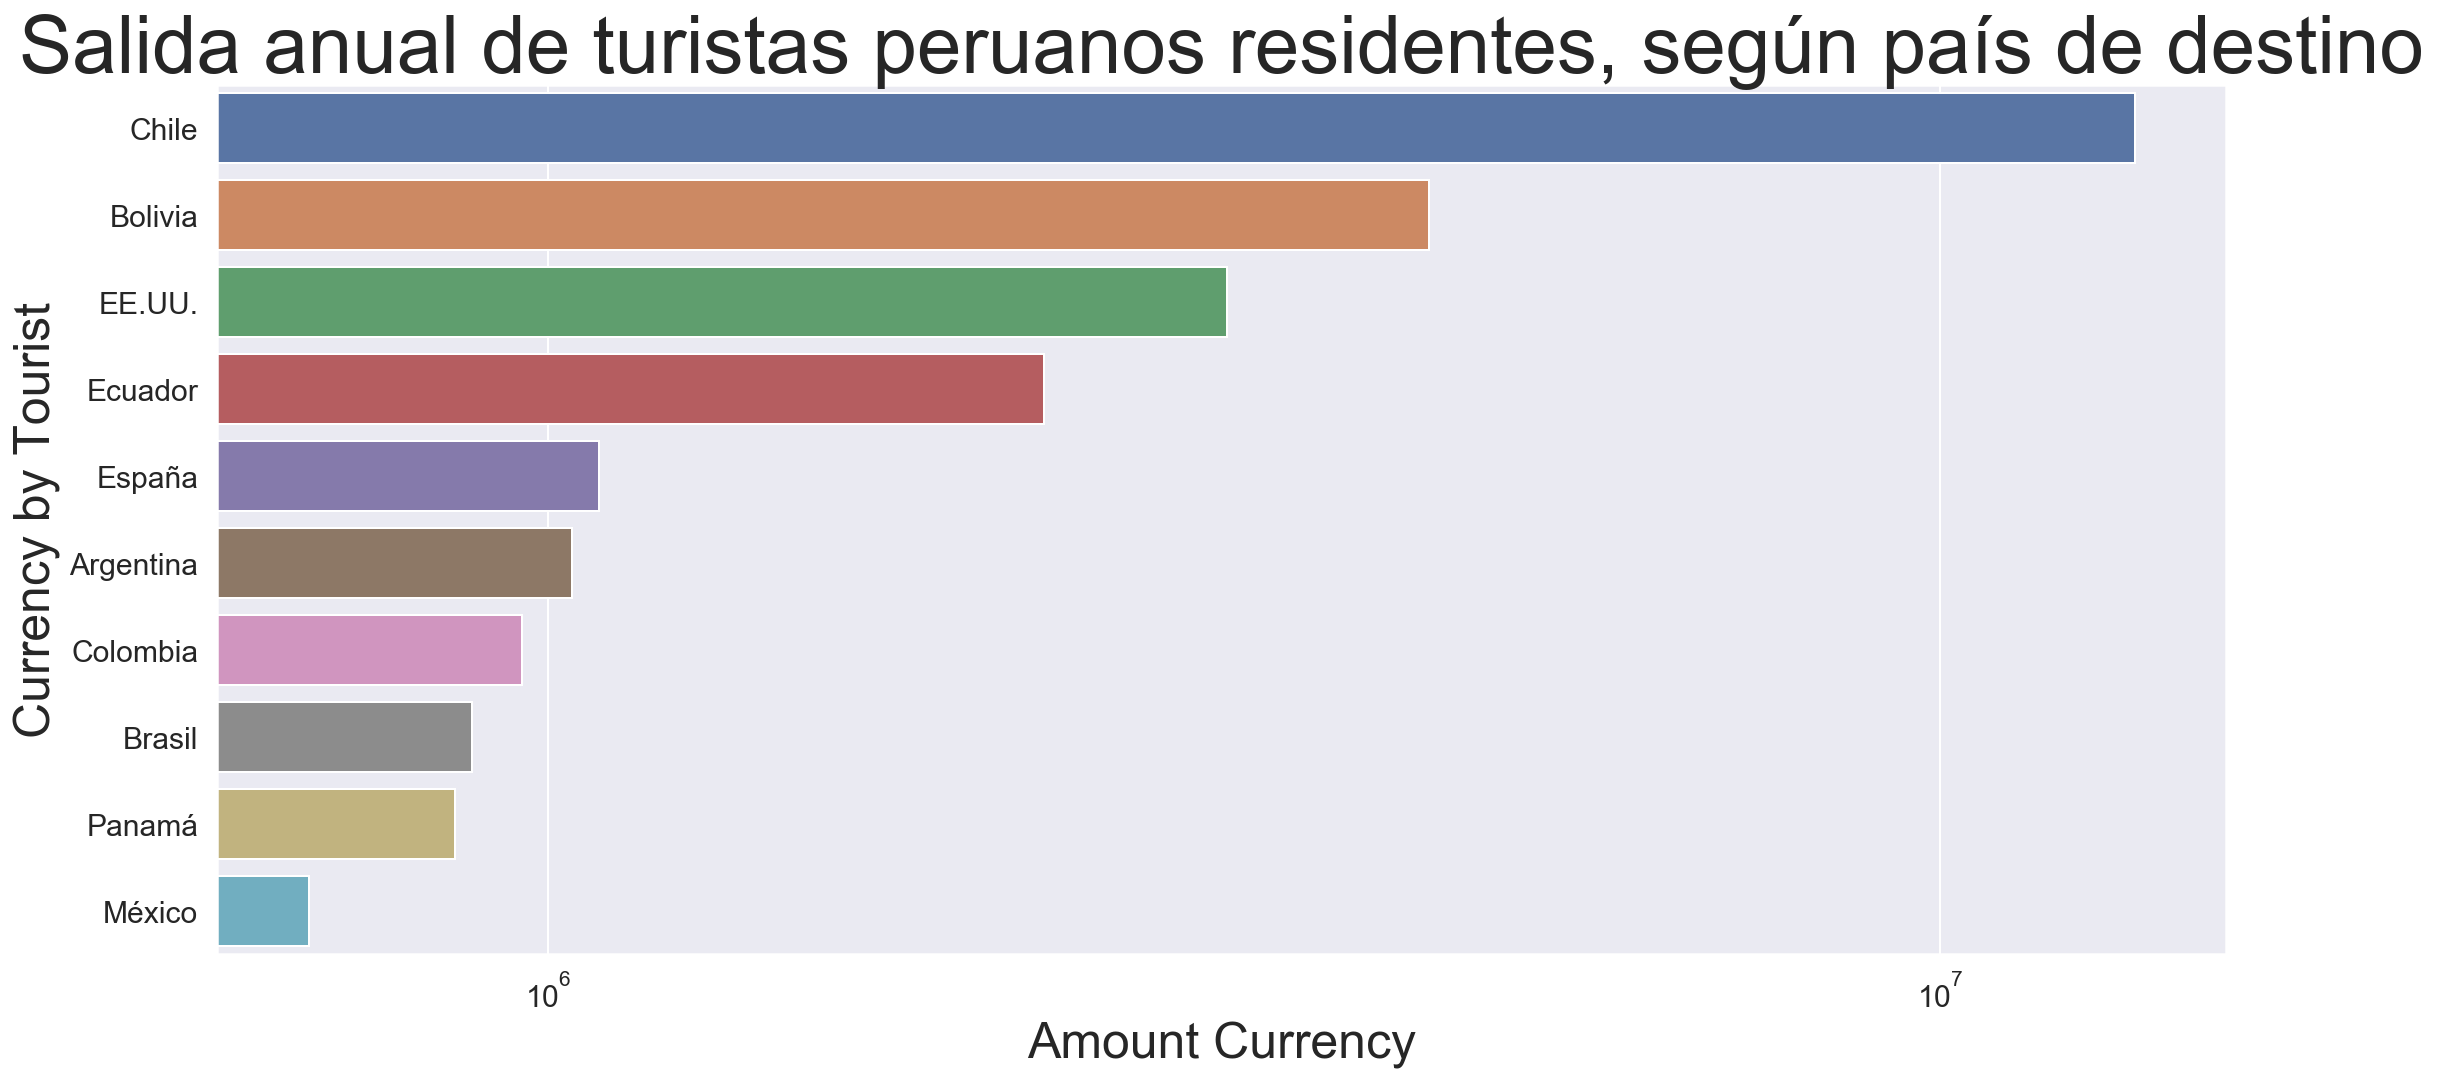

In [174]:
plt_dic = dict(y_label='Currency by Tourist',x_label='Amount Currency',scale='log')
show_by('salida_pais.xls',xls_dic,plt_dic,
        title='Salida anual de turistas peruanos residentes, según país de destino')

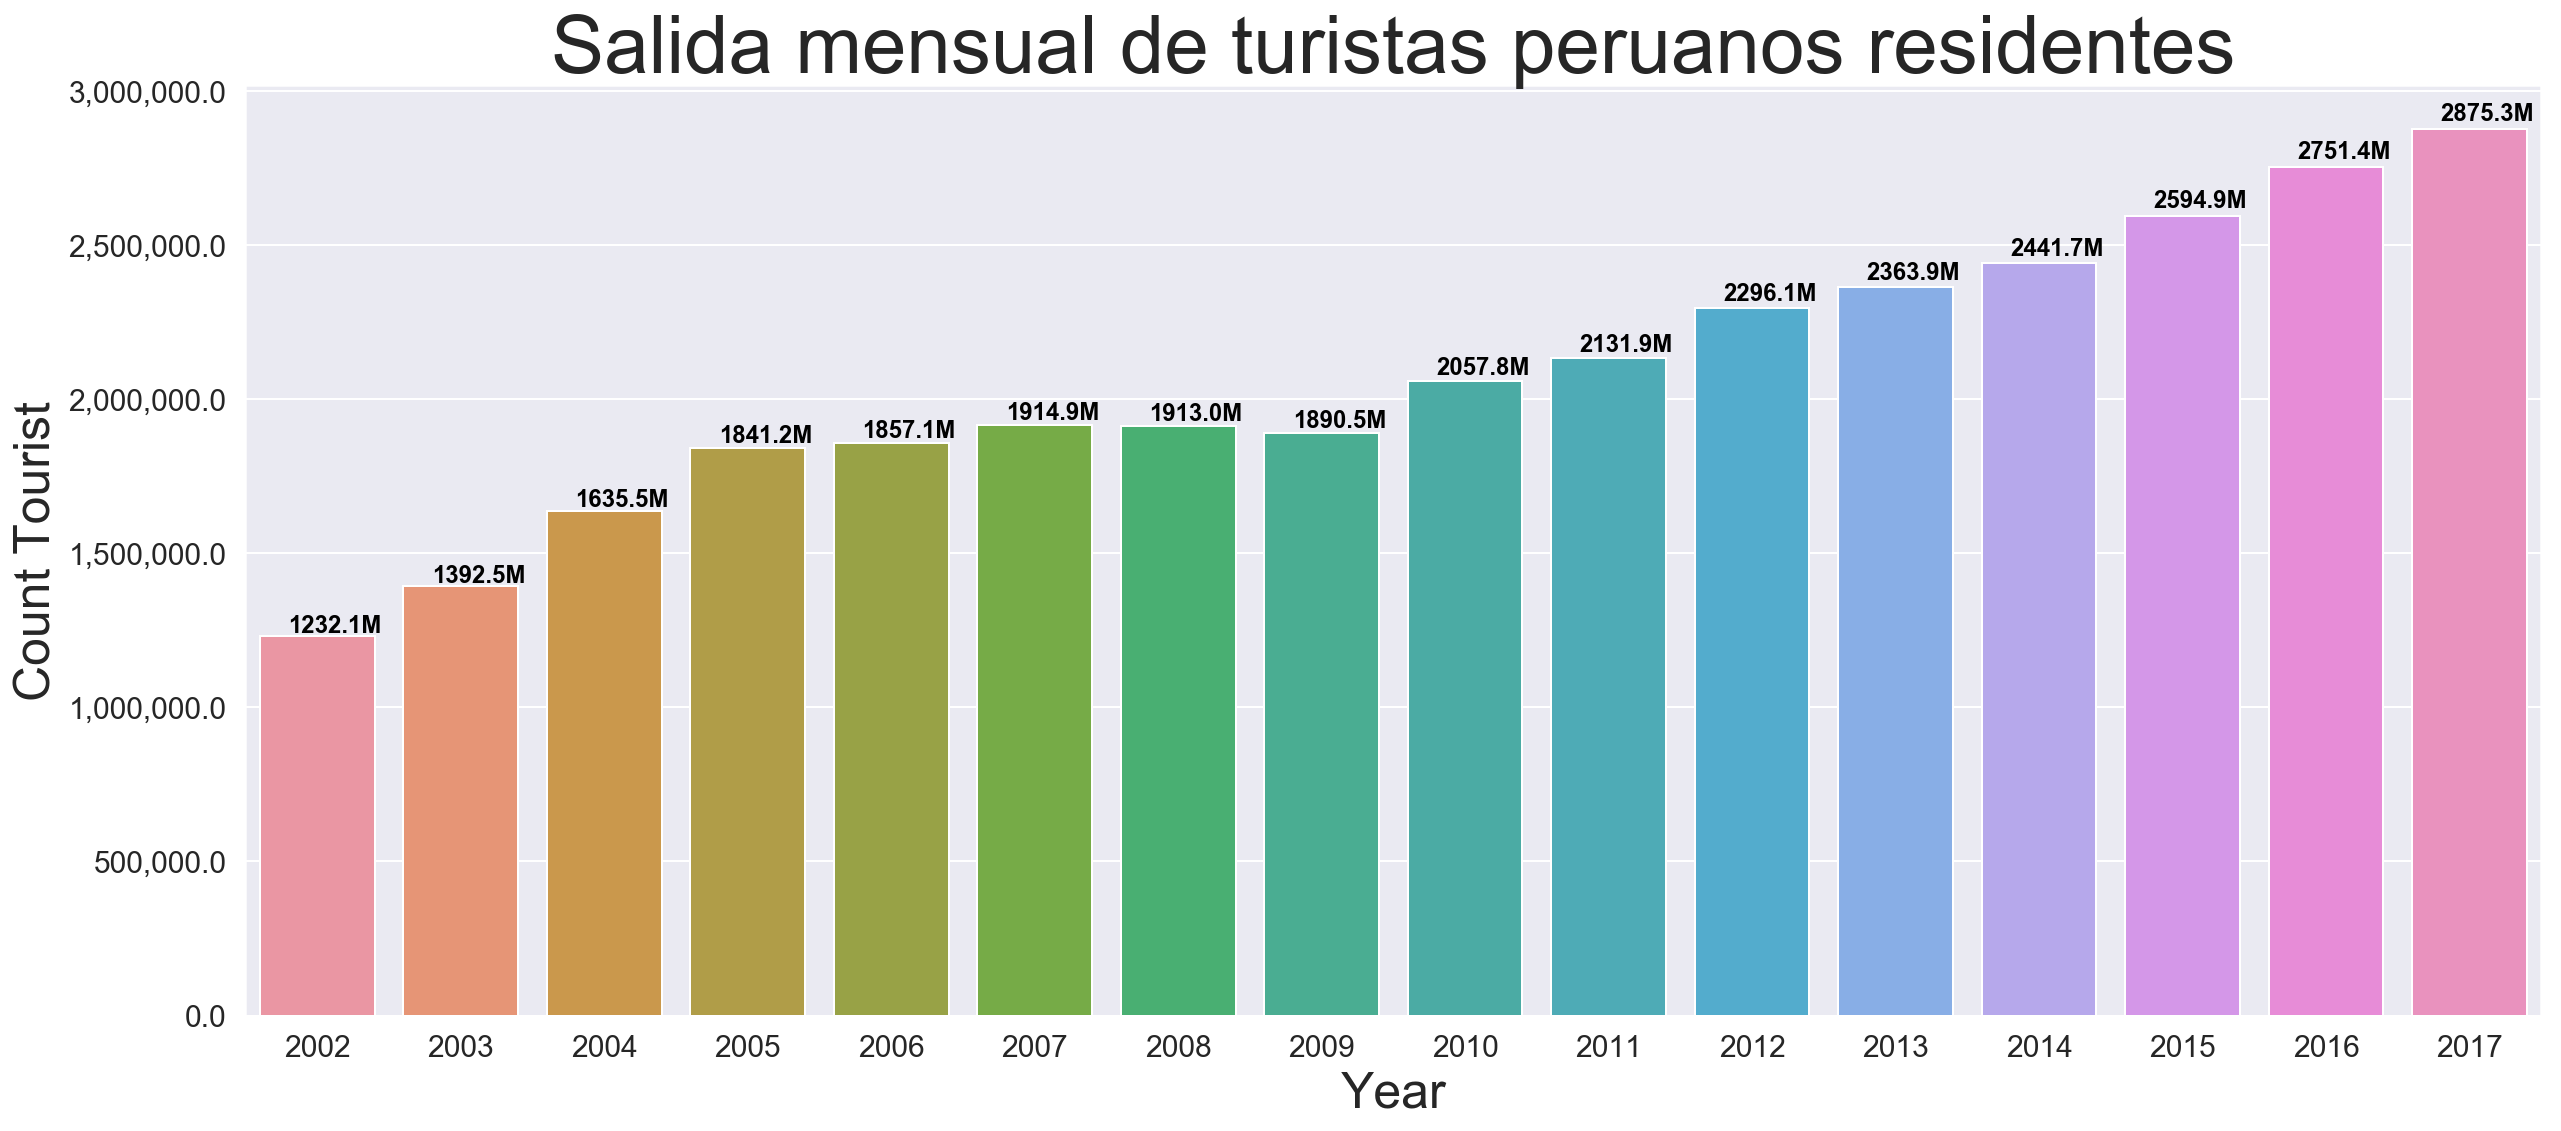

In [175]:
xls_dic = dict(sheet_name='rptaniomes',nrows=12,skiprows=3,index_col=0,)
plt_dic = dict(y_label='Count Tourist',)
show_data('salida_residentes.xls',xls_dic,plt_dic,drop=0,
        title='Salida mensual de turistas peruanos residentes')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0576      0.183     -0.315      0.753      -0.416       0.301
ma.L1         -0.5575      0.156     -3.582      0.000      -0.862      -0.252
ar.S.L12      -0.3547      0.076     -4.667      0.000      -0.504      -0.206
sigma2      4.852e+07    3.4e-10   1.43e+17      0.000    4.85e+07    4.85e+07


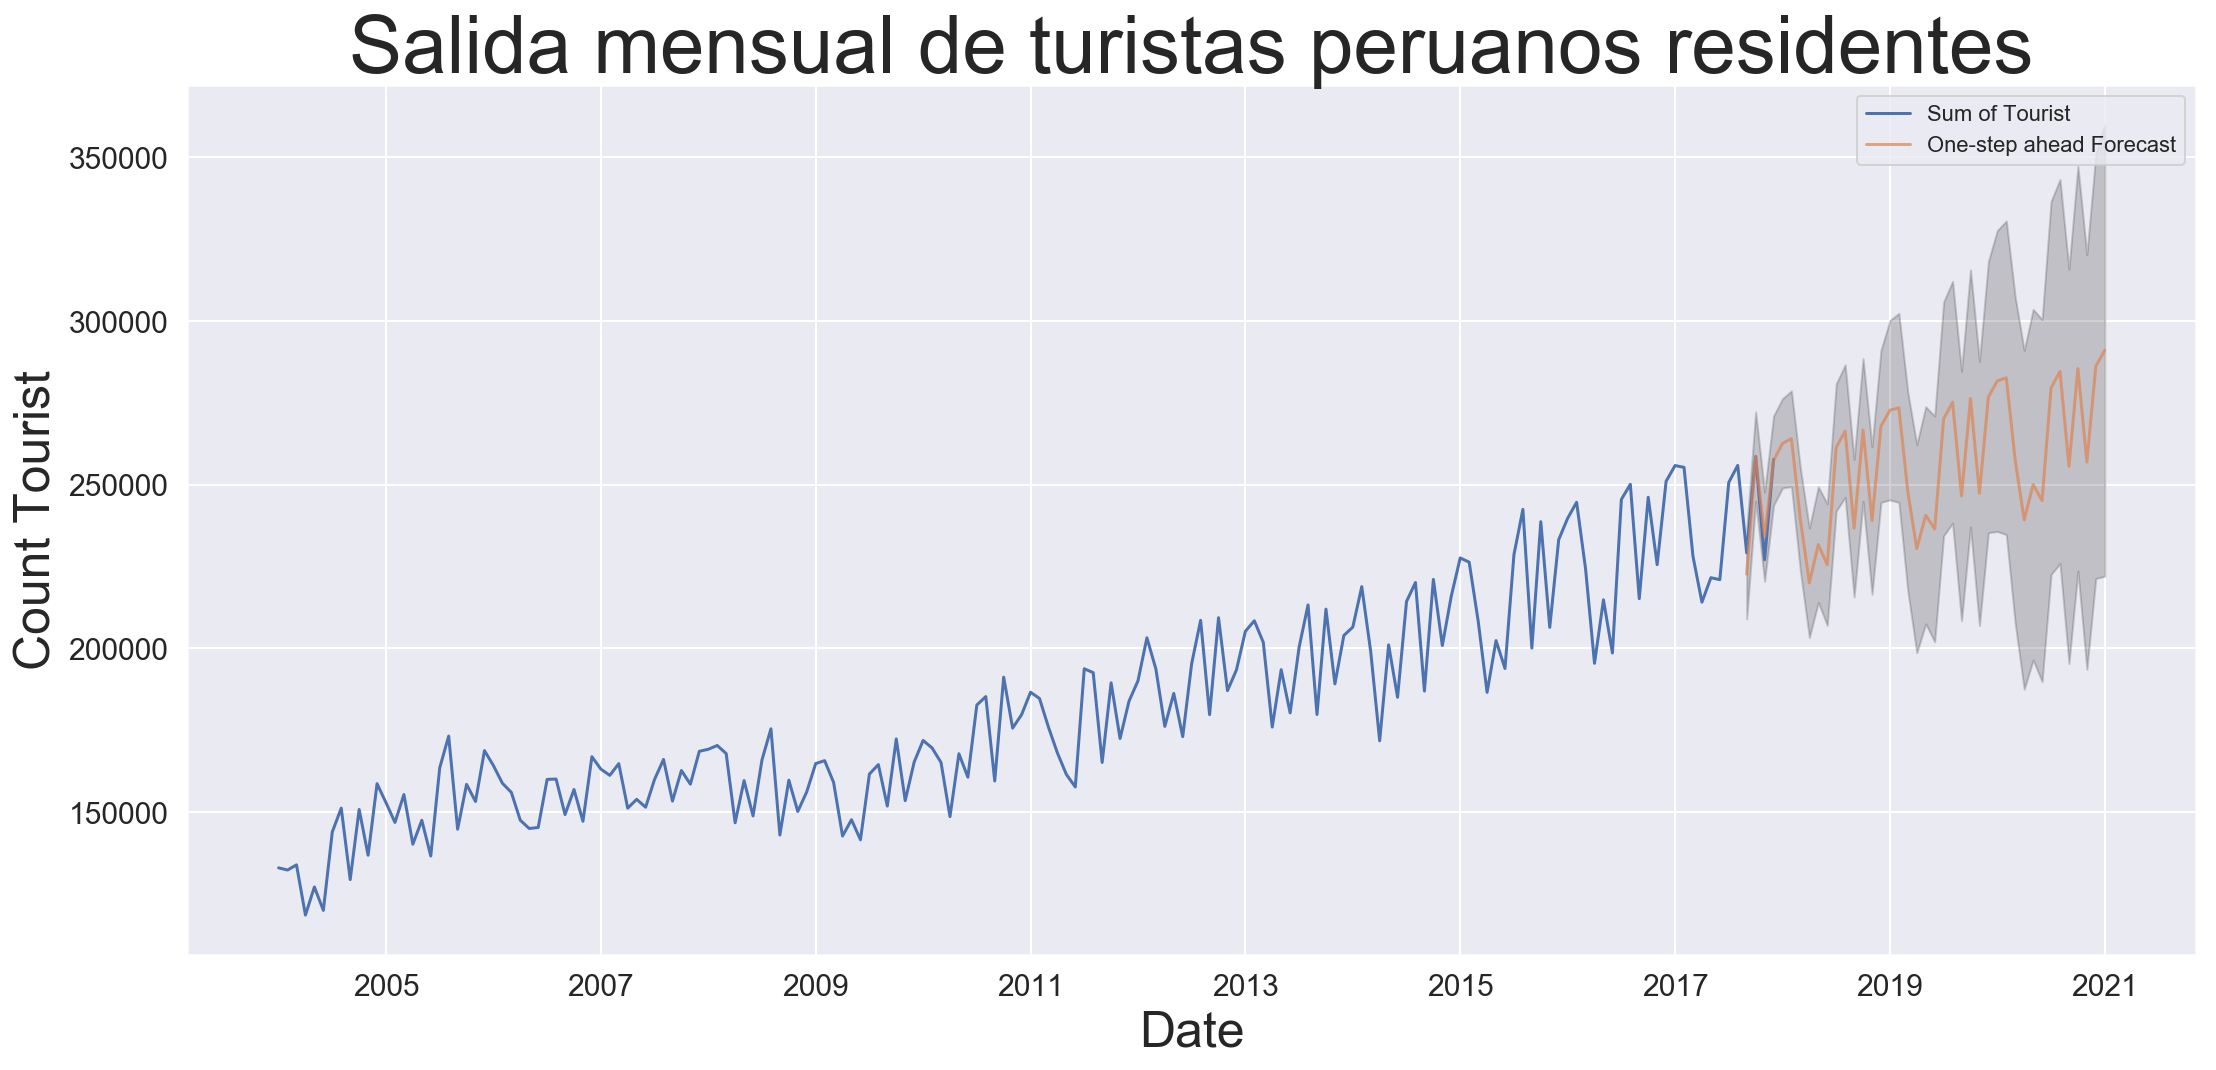

In [176]:
predict_plot('salida_residentes.xls',xls_dic,drop=0,
        title='Salida mensual de turistas peruanos residentes')